In [ ]:
!pip install transformers==4.14.1 -q
!pip install bitsandbytes-cuda111==0.26.0 -q
!pip install datasets==1.16.1 -q
!pip install bitsandbytes

ERROR: Could not find a version that satisfies the requirement bitsandbytes-cuda111==0.26.0 (from versions: 0.26.0.post2)
ERROR: No matching distribution found for bitsandbytes-cuda111==0.26.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import train_test_split

import transformers

import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch.cuda.amp import custom_fwd, custom_bwd

from bitsandbytes.functional import quantize_blockwise, dequantize_blockwise

from tqdm.auto import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Converting the model to 8 bits


In [ ]:
class FrozenBNBLinear(nn.Module):
    def __init__(self, weight, absmax, code, bias=None):
        assert isinstance(bias, nn.Parameter) or bias is None
        super().__init__()
        self.out_features, self.in_features = weight.shape
        self.register_buffer("weight", weight.requires_grad_(False))
        self.register_buffer("absmax", absmax.requires_grad_(False))
        self.register_buffer("code", code.requires_grad_(False))
        self.adapter = None
        self.bias = bias
 
    def forward(self, input):
        output = DequantizeAndLinear.apply(input, self.weight, self.absmax, self.code, self.bias)
        if self.adapter:
            output += self.adapter(input)
        return output
 
    @classmethod
    def from_linear(cls, linear: nn.Linear) -> "FrozenBNBLinear":
        weights_int8, state = quantize_blockise_lowmemory(linear.weight)
        return cls(weights_int8, *state, linear.bias)
 
    def __repr__(self):
        return f"{self.__class__.__name__}({self.in_features}, {self.out_features})"
 
class DequantizeAndLinear(torch.autograd.Function): 
  @staticmethod
  @custom_fwd
  def forward(ctx, input: torch.Tensor, weights_quantized: torch.ByteTensor,
              absmax: torch.FloatTensor, code: torch.FloatTensor, bias: torch.FloatTensor):
      weights_deq = dequantize_blockwise(weights_quantized, absmax=absmax, code=code)
      ctx.save_for_backward(input, weights_quantized, absmax, code)
      ctx._has_bias = bias is not None
      return F.linear(input, weights_deq, bias).clone()
 
  @staticmethod
  @custom_bwd
  def backward(ctx, grad_output: torch.Tensor):
      assert not ctx.needs_input_grad[1] and not ctx.needs_input_grad[2] and not ctx.needs_input_grad[3]
      input, weights_quantized, absmax, code = ctx.saved_tensors
      # grad_output: [*batch, out_features]
      weights_deq = dequantize_blockwise(weights_quantized, absmax=absmax, code=code)
      grad_input = grad_output @ weights_deq
      grad_bias = grad_output.flatten(0, -2).sum(dim=0) if ctx._has_bias else None
      return grad_input, None, None, None, grad_bias

class FrozenBNBEmbedding(nn.Module):
    def __init__(self, weight, absmax, code):
        super().__init__()
        self.num_embeddings, self.embedding_dim = weight.shape
        self.register_buffer("weight", weight.requires_grad_(False))
        self.register_buffer("absmax", absmax.requires_grad_(False))
        self.register_buffer("code", code.requires_grad_(False))
        self.adapter = None
 
    def forward(self, input, **kwargs):
        with torch.no_grad():
            # note: both quantuized weights and input indices are *not* differentiable
            weight_deq = dequantize_blockwise(self.weight, absmax=self.absmax, code=self.code)
            output = F.embedding(input, weight_deq, **kwargs)
        if self.adapter:
            output += self.adapter(input)
        return output 

    @classmethod
    def from_embedding(cls, embedding: nn.Embedding) -> "FrozenBNBEmbedding":
        weights_int8, state = quantize_blockise_lowmemory(embedding.weight)
        return cls(weights_int8, *state)
 
    def __repr__(self):
      return f"{self.__class__.__name__}({self.num_embeddings}, {self.embedding_dim})"



def quantize_blockise_lowmemory(matrix: torch.Tensor, chunk_size: int = 2 ** 20):
    assert chunk_size % 4096 == 0
    code = None
    chunks = []
    absmaxes = []
    flat_tensor = matrix.view(-1)
    for i in range((matrix.numel() - 1) // chunk_size + 1):
        input_chunk = flat_tensor[i * chunk_size: (i + 1) * chunk_size].clone()
        quantized_chunk, (absmax_chunk, code) = quantize_blockwise(input_chunk, code=code)
        chunks.append(quantized_chunk)
        absmaxes.append(absmax_chunk)
 
    matrix_i8 = torch.cat(chunks).reshape_as(matrix)
    absmax = torch.cat(absmaxes)
    return matrix_i8, (absmax, code)



def convert_to_int8(model):
    """Convert linear and embedding modules to 8-bit with optional adapters"""
    for module in list(model.modules()):
        for name, child in module.named_children():
            if isinstance(child, nn.Linear):
                print(name, child)
                setattr(
                    module,
                    name,
                    FrozenBNBLinear(
                        weight=torch.zeros(child.out_features, child.in_features, dtype=torch.uint8),
                        absmax=torch.zeros((child.weight.numel() - 1) // 4096 + 1),
                        code=torch.zeros(256),
                        bias=child.bias,
                    ),
                )
            elif isinstance(child, nn.Embedding):
                setattr(
                    module,
                    name,
                    FrozenBNBEmbedding(
                        weight=torch.zeros(child.num_embeddings, child.embedding_dim, dtype=torch.uint8),
                        absmax=torch.zeros((child.weight.numel() - 1) // 4096 + 1),
                        code=torch.zeros(256),
                    )
                )
 

You have to Monkey-Patch GPT-J before loading:


In [ ]:
class GPTJBlock(transformers.models.gptj.modeling_gptj.GPTJBlock):
    def __init__(self, config):
        super().__init__(config)

        convert_to_int8(self.attn)
        convert_to_int8(self.mlp)


class GPTJModel(transformers.models.gptj.modeling_gptj.GPTJModel):
    def __init__(self, config):
        super().__init__(config)
        convert_to_int8(self)
        

class GPTJForCausalLM(transformers.models.gptj.modeling_gptj.GPTJForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        convert_to_int8(self)


transformers.models.gptj.modeling_gptj.GPTJBlock = GPTJBlock

If you're using another 8-bit quantized model (e.g. T0-3B), remember to Monkey-Patch the model using convert_to_int8()



In [ ]:
class T5ForConditionalGeneration(transformers.models.t5.modeling_t5.T5ForConditionalGeneration):
    def __init__(self, config):
        super().__init__(config)
        convert_to_int8(self)

transformers.models.t5.modeling_t5.T5ForConditionalGeneration = T5ForConditionalGeneration

In [ ]:
config = transformers.GPTJConfig.from_pretrained("EleutherAI/gpt-j-6B")
tokenizer = transformers.AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")

In [ ]:
config.pad_token_id = config.eos_token_id
tokenizer.pad_token = config.pad_token_id

In [ ]:
gpt = GPTJForCausalLM.from_pretrained("hivemind/gpt-j-6B-8bit", low_cpu_mem_usage=True)
#gpt = GPTJForCausalLM.from_pretrained("gustavecortal/fr-boris-8bit", low_cpu_mem_usage=True) French GPT-J Cedille's Boris

k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, 

Add adapters to Embedding/MLP/Attention/LMHead layers



In [ ]:
def add_adapters(model, adapter_dim=4, p = 0.1):
    assert adapter_dim > 0

    for name, module in model.named_modules():
      if isinstance(module, FrozenBNBLinear):
          if "attn" in name or "mlp" in name or "head" in name:
              print("Adding adapter to", name)
              module.adapter = nn.Sequential(
                nn.Linear(module.in_features, adapter_dim, bias=False),
                nn.Dropout(p=p),
                nn.Linear(adapter_dim, module.out_features, bias=False),
            )
              print("Initializing", name)
              nn.init.zeros_(module.adapter[2].weight)

          else:
              print("Not adding adapter to", name)
      elif isinstance(module, FrozenBNBEmbedding):
          print("Adding adapter to", name)
          module.adapter = nn.Sequential(
                nn.Embedding(module.num_embeddings, adapter_dim),
                nn.Dropout(p=p),
                nn.Linear(adapter_dim, module.embedding_dim, bias=False),
            )
          print("Initializing", name)
          nn.init.zeros_(module.adapter[2].weight)

add_adapters(gpt)
device =  'cpu'
gpt.to(device)

Adding adapter to transformer.wte
Initializing transformer.wte
Adding adapter to transformer.h.0.attn.k_proj
Initializing transformer.h.0.attn.k_proj
Adding adapter to transformer.h.0.attn.v_proj
Initializing transformer.h.0.attn.v_proj
Adding adapter to transformer.h.0.attn.q_proj
Initializing transformer.h.0.attn.q_proj
Adding adapter to transformer.h.0.attn.out_proj
Initializing transformer.h.0.attn.out_proj
Adding adapter to transformer.h.0.mlp.fc_in
Initializing transformer.h.0.mlp.fc_in
Adding adapter to transformer.h.0.mlp.fc_out
Initializing transformer.h.0.mlp.fc_out
Adding adapter to transformer.h.1.attn.k_proj
Initializing transformer.h.1.attn.k_proj
Adding adapter to transformer.h.1.attn.v_proj
Initializing transformer.h.1.attn.v_proj
Adding adapter to transformer.h.1.attn.q_proj
Initializing transformer.h.1.attn.q_proj
Adding adapter to transformer.h.1.attn.out_proj
Initializing transformer.h.1.attn.out_proj
Adding adapter to transformer.h.1.mlp.fc_in
Initializing transfor

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): FrozenBNBEmbedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): FrozenBNBLinear(4096, 4096)
          (v_proj): FrozenBNBLinear(4096, 4096)
          (q_proj): FrozenBNBLinear(4096, 4096)
          (out_proj): FrozenBNBLinear(4096, 4096)
        )
        (mlp): GPTJMLP(
          (fc_in): FrozenBNBLinear(4096, 16384)
          (fc_out): FrozenBNBLinear(16384, 4096)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0

In [ ]:
from bitsandbytes.optim import Adam8bit

gpt.gradient_checkpointing_enable()
optimizer = Adam8bit(gpt.parameters(), lr=1e-5, weight_decay=0.01)

###Load dataset 

In [ ]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={'train': '/content/wiki_to_fine_f_train.csv',
                                              'test': '/content/wiki_to_fine_f_train.csv'})

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 7977
    })
    test: Dataset({
        features: ['text'],
        num_rows: 7977
    })
})

In [ ]:

def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length= 128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

from torch.utils.data import DataLoader

full_train_dataset = tokenized_datasets["train"]
train_dataloader = DataLoader(full_train_dataset, shuffle=False, batch_size=8)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [ ]:
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer, int(num_training_steps*0.1), num_training_steps
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpt.to(device)

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): FrozenBNBEmbedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): FrozenBNBLinear(4096, 4096)
          (v_proj): FrozenBNBLinear(4096, 4096)
          (q_proj): FrozenBNBLinear(4096, 4096)
          (out_proj): FrozenBNBLinear(4096, 4096)
        )
        (mlp): GPTJMLP(
          (fc_in): FrozenBNBLinear(4096, 16384)
          (fc_out): FrozenBNBLinear(16384, 4096)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0

In [ ]:
from tqdm.auto import tqdm

scaler = torch.cuda.amp.GradScaler()
progress_bar = tqdm(range(num_training_steps))
gpt.train()
gpt.gradient_checkpointing_enable()
k = 0
losses = []
count = 0 

for epoch in range(num_epochs):
    for batch in train_dataloader:

        k = k + 1
        if k % 500 == 0:
          print(k)
        

        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
          out = gpt.forward(**batch,)

          loss = F.cross_entropy(out.logits[:, :-1, :].flatten(0, -2), batch['input_ids'][:, 1:].flatten(),
                                reduction='mean', label_smoothing=0.1)
          
        print(loss)
        losses.append(loss.item())
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(gpt.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        lr_scheduler.step()
        progress_bar.update(1)

  0%|          | 0/4925 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1891, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.8370, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.6565, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.4715, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.6606, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.2820, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.8683, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.4497, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3732, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3066, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.9798, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.8055, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.4508, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3688, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.2940, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1336, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.4533, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.5637, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.9797, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3124, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.0517, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1166, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3312, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.0029, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.4309, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.5201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.5510, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3714, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.5465, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(9.0607, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.6337, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.7228, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.5090, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3702, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1133, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1050, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.7176, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.9950, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.2006, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.7284, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.9708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.9200, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.8271, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.5096, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.7201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.7132, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.7094, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.0725, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3063, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.0401, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3639, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.4761, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3491, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.4182, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1175, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1322, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1706, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.5564, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.4364, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.0679, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.4597, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1132, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.9463, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3392, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.5102, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3063, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.0476, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.7493, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.0694, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.9810, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.2775, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.3776, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.3074, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.3800, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.0337, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.4879, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.6379, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.7827, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.4394, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.7031, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.2896, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.6135, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.1381, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.3079, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.9739, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.2194, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.4739, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.9231, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.5895, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.4970, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.0575, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.5086, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.8802, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.0046, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.6316, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.4474, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.4388, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.2038, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.7334, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.6330, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.5597, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.5617, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.1989, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.8573, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.0713, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.2248, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1370, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.7272, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.6650, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.6569, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(8.1372, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.8811, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.3421, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.0732, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.5070, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.8949, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.2236, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.3448, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.3305, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.4773, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.6271, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.7365, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.9473, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.6494, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.0306, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.9319, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.2749, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.5021, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.5208, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.2636, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.4156, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.2918, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.2490, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.8252, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.0336, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.3634, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.5984, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.0115, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.0062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.6012, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.2109, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.8283, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.7663, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.2754, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.6709, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.4828, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(7.0857, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.9622, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.3212, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.7606, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.8116, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.2100, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.0571, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.9290, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.3989, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.7305, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.3908, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.2127, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.5287, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.3155, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.9015, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.6164, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.5255, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.3760, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.1830, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.8651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.1080, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(6.1640, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.9902, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.4386, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.5883, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.9432, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.7476, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.5983, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.4394, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.5074, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.6321, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.1412, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.4530, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.3028, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.3070, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.7795, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.1404, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(5.0594, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.8545, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.6998, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.9007, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.5944, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.5267, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.4365, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.2628, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.2143, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(4.0042, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.7823, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.7509, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.6297, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.4733, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.5289, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.9878, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.8323, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.8815, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7501, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7646, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4432, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6663, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7025, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6376, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5471, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6627, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4641, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4877, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4260, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6474, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4504, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3723, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6632, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4887, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4053, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3699, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4565, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4033, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4294, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3818, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4498, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4724, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5396, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2117, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2898, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3386, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3032, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6046, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2155, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3122, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2252, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2031, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2174, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3143, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1891, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1527, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0577, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3211, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0656, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1510, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0519, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2194, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0734, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0723, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1926, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0604, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0142, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0985, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1819, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1842, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1356, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0688, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0879, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1820, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1487, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0975, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0783, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1199, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0920, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0311, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0999, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0570, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0112, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9431, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1220, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9541, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0964, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0717, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0514, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0152, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1730, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0731, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0479, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1152, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0094, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1432, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1031, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0862, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0730, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1291, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9930, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0869, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9622, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0316, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0402, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0745, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9327, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0078, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9841, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1160, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9841, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9719, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1590, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0800, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1503, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9679, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9046, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9813, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0951, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0143, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9544, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0234, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9408, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0441, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9287, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8848, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9083, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9803, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9904, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0371, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0172, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9718, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9968, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0272, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9406, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8795, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9659, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8721, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0142, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0495, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8798, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9502, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0025, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0064, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0753, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0153, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8877, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8105, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0514, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8108, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9342, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0465, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9892, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0147, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9744, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9370, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0372, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9129, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9641, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0044, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0844, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9897, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9039, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9711, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9489, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0148, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9476, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0075, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1767, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9898, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0877, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8722, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0522, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9103, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0098, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1000, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8805, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9430, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7971, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0645, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9534, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0917, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9823, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9360, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8621, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8634, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9225, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8846, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9289, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0066, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0403, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2109, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9059, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9963, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0327, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0461, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8962, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0073, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9681, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9351, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9305, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8630, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0174, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9570, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7977, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0000, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8814, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9540, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8041, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8854, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9046, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9514, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9028, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9221, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9242, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9974, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9381, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0577, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8785, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9914, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9251, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9668, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0555, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8633, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9992, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8389, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0285, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9872, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8807, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0293, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9223, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1107, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0374, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9051, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0055, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0933, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0190, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0563, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9749, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9136, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8915, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9243, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0087, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8792, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9544, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0099, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0266, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9609, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0038, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0218, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8971, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9498, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9047, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9194, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9034, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8703, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0307, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0254, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9537, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8489, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8952, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8478, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9805, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0902, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9908, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8471, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9042, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9202, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9790, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9986, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0541, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8017, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0217, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9396, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9554, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9759, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9395, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9263, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8624, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8226, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8748, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9254, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8218, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9080, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0239, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0192, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8019, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8611, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0236, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0004, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9424, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8896, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0078, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8833, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0693, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9647, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0146, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9186, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0857, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9321, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8234, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0421, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9926, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8950, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8164, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8912, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8758, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0003, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9513, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0342, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9146, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0676, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


500
tensor(1.8991, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9227, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9577, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9650, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9246, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9272, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9461, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9387, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0108, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8290, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8027, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0242, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9843, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0510, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0736, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9966, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9660, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8652, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8693, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8925, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9665, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8543, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8720, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9897, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8361, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9884, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0451, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0296, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8704, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8865, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9300, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8488, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9921, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0436, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0339, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9641, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7957, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9008, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8477, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9982, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9175, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8997, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8324, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9681, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0284, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9670, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9313, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8683, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9441, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9362, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9760, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8815, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8685, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8701, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0264, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0822, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8966, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0369, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9479, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9052, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8711, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9801, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8321, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8389, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8845, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0199, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9661, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8060, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8639, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0533, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0541, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0051, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8521, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8685, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0225, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9390, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0363, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9758, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9275, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9185, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9339, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8810, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9015, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0347, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9100, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8709, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8858, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7885, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8594, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7993, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8612, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0242, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8874, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8657, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8822, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9517, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8725, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9443, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8754, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9219, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9743, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9082, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8345, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9960, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9658, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9573, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9962, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8904, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9557, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9442, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8403, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7919, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8945, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9722, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7820, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8200, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9019, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8613, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0043, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9900, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8241, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9796, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8955, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8874, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8199, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9848, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9341, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8657, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9511, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8799, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8865, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8950, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9586, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9714, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8889, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9200, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9655, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0491, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8144, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8807, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0667, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0315, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7548, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9391, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0180, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8785, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0043, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9862, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9002, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8467, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9471, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8789, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9820, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9596, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8405, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8421, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9173, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8597, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9072, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8059, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8679, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9002, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0278, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9412, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0420, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8310, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9856, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7895, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9527, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8152, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8562, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8344, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8572, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8204, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9132, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9038, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8069, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8610, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8596, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9053, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8687, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8903, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8566, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8409, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9565, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8553, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0995, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9497, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8134, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1670, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8117, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8172, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9767, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0152, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9803, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9770, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8206, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8903, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0513, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8526, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9899, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9053, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8417, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9363, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8877, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9832, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8668, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9198, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8836, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9036, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8113, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8030, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8424, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8886, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8542, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8506, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9853, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8697, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9950, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9214, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7859, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8810, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9340, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8154, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8737, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9261, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8543, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8542, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9103, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0273, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9642, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9122, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9442, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8890, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9473, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8641, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8896, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9092, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9161, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0926, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9419, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9352, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8796, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8950, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0920, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9059, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8981, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9803, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0101, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9450, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8801, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9418, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9208, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9886, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9698, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8722, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8613, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0837, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8530, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8070, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9983, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8475, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8053, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9956, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9431, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8892, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8615, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9220, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8251, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9508, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8215, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9559, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7984, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9347, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8418, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8182, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9516, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8917, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8877, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9751, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9801, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9305, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8495, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9578, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8724, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9298, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8587, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9504, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8705, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7609, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9203, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9343, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8963, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8888, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8225, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7863, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8672, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0032, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0800, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8723, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8900, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9269, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8435, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9453, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9129, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9616, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9911, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8895, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8250, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9934, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7369, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9293, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9644, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9017, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9264, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9381, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9076, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8442, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8637, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8726, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8904, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8706, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9054, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9753, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8681, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7802, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9033, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8006, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8589, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0131, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0176, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9172, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9709, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9951, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8003, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7851, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8761, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9186, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8270, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2074, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9809, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9401, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9697, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9464, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8228, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7733, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9643, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8367, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9167, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9899, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9052, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8428, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9875, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9139, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9760, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8652, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9496, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9581, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9701, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8101, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7750, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7658, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8512, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8889, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8056, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8631, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7918, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8742, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7875, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8449, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8593, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9482, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8462, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9106, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7829, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8914, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8240, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8042, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8410, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9482, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8581, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9171, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8328, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8248, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8470, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8161, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8525, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1139, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9261, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9780, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9444, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1282, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8267, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0858, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8711, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9796, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9521, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9093, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8869, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8961, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8795, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0510, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0418, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8841, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9599, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0605, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8266, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9248, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8299, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9075, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8782, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9422, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8919, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8487, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7852, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8738, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8587, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8103, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9333, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8712, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8774, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8997, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8545, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8432, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8847, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8923, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9663, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8423, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8494, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8709, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9355, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9567, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0425, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8583, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9883, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8288, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8991, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8970, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9123, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0120, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9614, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8314, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8383, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9991, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8223, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9133, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9334, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8697, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9502, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8836, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8983, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9155, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9847, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9522, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8067, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8961, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9843, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9691, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9070, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8119, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8806, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8694, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9137, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8723, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9679, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7924, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9109, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9206, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8079, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8684, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8923, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9376, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8321, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8342, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9394, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9959, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9249, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8311, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8962, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8811, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8644, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8853, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8700, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8532, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7098, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8996, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8681, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8580, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9476, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9352, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


1000
tensor(1.8667, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8873, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8982, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8319, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9256, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9138, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9580, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8939, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8813, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0350, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7858, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9401, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8489, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9038, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0107, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8930, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8038, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8354, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8247, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8513, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9518, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9638, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9344, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9115, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8908, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9922, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7709, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9440, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7542, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8936, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9776, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7422, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9333, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8897, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8305, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8918, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9728, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9480, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8801, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8442, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9310, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2443, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8160, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9127, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8110, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0047, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9534, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9384, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9582, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0193, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9102, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9191, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8234, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9693, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8170, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8236, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9112, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9378, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9664, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9174, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9140, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9784, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8973, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8898, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8418, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9356, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0492, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9619, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9465, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9875, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9896, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8674, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9163, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0280, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7932, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9683, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7351, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7846, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0002, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0275, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8726, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9944, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8621, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8730, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9208, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9346, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9834, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9033, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8333, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9234, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8026, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9178, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9930, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8592, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8606, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9693, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0148, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9073, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8630, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8035, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8849, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9147, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8717, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9264, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7921, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9446, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9666, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8090, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8252, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0222, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8502, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8228, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8021, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8187, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0093, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8140, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9594, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8964, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8972, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9682, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0948, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9245, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8479, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9755, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8866, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8192, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8976, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0141, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8960, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9217, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7982, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7564, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9586, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8008, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8336, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0069, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1443, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0003, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9179, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8442, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7962, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8267, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8953, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9726, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7621, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7990, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8600, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8195, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0577, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8641, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9279, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8048, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0750, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0503, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8976, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8404, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8686, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8993, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8902, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7059, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9407, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9225, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8562, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7471, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0269, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9031, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8532, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8854, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8323, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7921, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9613, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8289, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8638, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8089, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8003, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9595, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8680, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9045, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8114, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8930, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1004, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8336, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8090, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9489, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8961, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9700, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7978, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8966, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9679, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8503, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8935, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9743, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7824, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8599, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8257, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0376, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8528, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8442, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0796, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9526, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8586, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8786, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9481, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9306, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9521, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9088, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9770, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9988, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0509, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8094, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8706, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8331, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8869, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1449, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7745, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9172, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8061, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8637, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8688, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9669, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9077, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8194, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7475, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0297, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7798, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8248, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7577, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9267, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7544, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7464, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9240, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7578, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7630, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8036, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9338, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9310, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7831, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8843, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8446, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9734, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9018, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9070, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8381, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8720, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8900, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8436, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9392, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8775, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8340, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7439, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9462, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8271, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8242, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9411, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8484, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8411, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8173, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9767, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9249, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9206, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8961, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8595, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9154, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9243, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9549, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9149, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9805, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8573, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9381, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8070, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8944, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9018, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9047, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7908, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8900, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8553, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9895, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8606, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8389, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9940, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9237, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0348, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7886, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7740, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8329, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8811, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8588, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9123, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8322, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8929, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8128, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7887, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8374, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8755, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8679, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9034, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9188, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8545, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9085, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9346, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8066, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7780, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8406, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7796, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9281, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9652, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7936, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8495, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9020, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8991, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9824, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9289, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7968, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7350, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9410, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7426, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8295, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9439, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8532, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9101, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9034, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8451, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9436, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8164, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8864, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8632, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9817, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9116, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8272, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8893, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8424, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9257, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8843, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9283, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1033, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9137, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9834, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7397, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9618, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8447, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9418, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0104, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7874, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8752, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7233, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9994, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8650, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0056, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8966, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8593, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7946, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7815, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8221, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8462, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8544, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9188, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9670, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0954, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8514, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9131, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9141, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9535, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8222, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9236, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8925, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8873, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8634, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7860, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9020, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9396, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8921, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7628, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9190, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8270, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8840, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7281, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8248, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8508, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8728, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8298, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8398, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8704, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9111, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8793, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8016, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9244, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8578, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8972, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9835, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8205, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9381, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7709, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9470, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9148, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7825, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9635, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8616, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0132, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9769, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8461, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9542, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0355, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9329, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9903, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9098, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8355, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8339, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8531, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9390, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8163, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9629, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8926, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9457, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9765, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8988, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9491, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9583, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8270, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8842, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8312, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8629, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8445, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8070, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9947, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9619, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9004, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7983, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8335, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8032, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9103, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8767, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0028, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9308, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7953, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8530, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8498, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9152, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9315, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9917, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7496, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9434, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8747, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8902, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9195, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8752, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8337, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8081, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7502, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8242, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8716, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7491, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8291, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9393, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9469, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7243, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7955, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9288, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9402, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8647, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8535, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8846, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8134, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9877, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9038, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9485, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8590, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9942, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8790, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7310, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9749, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9350, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8318, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7568, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8372, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8087, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9329, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8962, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9539, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8507, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8385, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8604, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9024, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9251, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8762, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8742, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8875, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8642, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9452, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7758, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7240, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9634, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9330, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9572, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0063, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


1500
tensor(1.9386, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9081, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8179, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7957, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8157, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9143, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7779, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8257, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9218, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7717, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9313, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9697, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9729, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8188, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8481, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8751, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8004, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8932, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9604, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9801, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7475, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8388, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7883, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9505, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8641, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8447, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7821, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9105, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9630, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9072, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8678, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8215, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8032, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8600, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8830, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9304, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8337, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8077, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8285, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9699, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0000, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8569, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9809, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8895, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8459, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8338, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8240, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9100, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7855, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7900, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8244, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9646, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9144, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7686, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8155, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9671, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9941, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9494, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8158, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8262, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9521, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8819, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9776, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9327, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8576, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8799, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8833, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8909, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8287, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8652, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9906, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8458, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8134, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8383, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7572, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8047, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7410, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8139, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9852, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8309, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8355, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8435, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9069, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8205, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8760, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8411, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8804, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9266, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8693, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7597, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9434, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9180, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9194, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9397, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8632, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9138, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9059, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7948, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7457, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8644, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9151, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7345, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7707, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8391, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8076, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9550, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9208, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7883, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9160, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8348, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8460, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7782, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8540, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9199, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8809, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8354, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9028, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8193, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8292, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8436, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9139, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9173, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8544, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8726, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9156, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9985, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7468, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8219, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9993, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9988, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7106, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9063, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8960, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9596, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8349, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9282, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9336, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8359, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8137, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8861, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8294, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9257, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9047, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7917, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8267, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8692, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8126, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8513, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7632, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8283, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8682, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9854, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8810, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0017, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7956, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9339, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7594, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9054, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9048, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7749, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8230, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7739, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8180, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7725, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8732, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8485, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7706, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8115, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8274, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8577, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8249, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8377, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8195, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8081, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9231, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8010, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0301, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9031, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7808, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0947, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7773, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7819, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9191, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9475, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9485, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9473, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7718, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8435, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0027, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7803, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9364, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8632, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8794, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8239, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9365, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8323, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8808, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8314, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8569, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7694, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7640, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8431, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8135, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8049, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9324, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8102, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9664, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8689, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7509, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8185, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9054, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7732, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8214, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8803, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8170, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8140, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8632, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9764, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9015, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8832, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8878, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8383, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9163, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8330, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8490, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8668, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8695, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0278, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8913, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8996, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8329, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8379, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0306, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8705, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8525, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9347, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9546, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9049, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8446, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8890, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8823, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9351, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9217, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8264, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8086, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0401, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7848, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8415, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7605, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9382, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8023, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7704, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9460, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9093, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8580, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8175, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8693, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7917, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9032, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7832, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9068, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7408, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8812, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7990, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7791, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8943, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8406, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8414, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9255, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9275, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8744, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8192, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9383, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8105, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8819, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8775, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8356, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7199, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8804, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8859, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8487, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8564, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7786, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7433, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8271, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9601, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0355, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8273, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8447, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8937, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8068, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8956, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8738, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9208, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9375, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8494, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7804, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9549, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7006, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8975, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8575, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8790, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9025, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8728, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8071, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8220, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8076, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8509, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8177, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8585, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9325, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8267, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7303, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8638, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7695, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8187, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9553, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9699, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8751, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9196, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9375, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7788, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7311, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8375, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8661, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7934, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1364, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9326, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9003, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8824, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7808, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7414, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9751, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7893, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8856, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9670, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8041, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9191, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8732, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9328, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8219, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8933, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9200, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9235, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7743, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7434, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7362, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8206, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8352, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7612, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8077, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7622, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8379, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7519, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8031, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8055, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9003, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8089, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8807, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7666, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8421, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7868, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7650, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8108, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8164, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8671, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8033, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7957, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7871, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7950, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8169, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0304, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8675, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9299, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9008, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0630, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7871, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0319, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8372, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9349, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9079, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8508, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8488, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8663, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8441, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9973, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9988, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8439, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9241, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0141, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7973, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8917, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7940, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8704, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8341, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8835, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8561, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8096, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7530, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8397, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8082, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7810, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8980, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8342, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8398, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8596, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8128, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8138, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8548, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8435, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9227, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7918, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8119, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8320, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8907, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9002, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0015, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8168, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9508, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7762, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8481, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8570, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8670, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9592, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9243, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7874, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8044, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9421, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7871, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8583, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8832, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8351, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9078, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8580, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8487, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8816, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9318, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9081, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7649, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8477, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9385, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9247, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9150, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7741, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8402, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8284, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8805, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8393, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9128, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7315, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8775, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8888, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7716, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8244, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8338, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8801, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7966, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7944, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9058, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9525, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8864, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7856, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7800, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8378, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8289, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8291, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8456, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8219, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8084, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6829, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8248, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8890, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9535, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8244, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9002, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8893, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8196, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8469, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8611, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7874, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8876, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8668, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9227, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8528, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8441, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9762, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7358, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8924, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8074, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8706, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9497, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


2000
tensor(1.7400, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8467, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7636, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8243, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8032, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7790, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8253, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9079, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9162, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8977, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8741, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8435, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9447, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7390, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9036, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7144, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8488, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9324, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7114, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8962, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8506, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7935, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8525, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9300, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8927, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8359, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7894, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8784, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1741, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7799, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8711, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7687, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9671, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9093, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8780, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8865, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9758, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8669, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8806, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7900, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7812, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7835, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8714, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8968, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9142, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8711, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8635, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9256, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8581, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8439, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7936, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8862, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0017, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9220, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9016, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9319, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9299, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8653, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9914, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7543, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9238, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6880, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7531, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9489, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9706, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8402, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9423, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8236, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8274, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8850, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8991, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9323, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8646, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7871, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8829, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7560, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8816, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9563, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8071, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8165, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9280, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9726, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8627, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8195, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7634, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8463, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8633, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8432, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8705, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7481, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9089, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9131, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7660, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7711, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9691, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8113, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7906, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7660, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7781, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9615, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7737, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9135, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8544, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8503, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9177, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0460, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8758, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8012, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9369, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8449, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7856, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8595, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9556, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8475, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8640, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7625, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7108, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9060, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7685, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8036, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9530, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0913, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9502, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7601, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8695, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7901, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7567, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7970, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8560, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9180, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7180, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7671, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8233, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7747, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0072, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8162, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8775, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7817, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0141, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9890, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8499, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8039, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8283, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8527, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8429, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6775, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8932, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8798, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8087, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7110, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9670, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8613, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8116, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8427, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7884, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7602, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9216, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7978, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8364, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7801, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7624, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9040, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8342, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8627, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7799, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8395, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0508, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7929, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7736, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9106, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8457, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9322, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7582, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8461, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9266, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7987, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8503, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9272, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7417, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8296, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7857, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9809, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8083, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8119, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0260, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9081, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8163, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8319, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9093, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8898, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9055, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8700, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9581, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9875, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7892, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8390, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7704, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8395, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0870, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7362, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8780, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7715, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8289, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8394, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9189, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8699, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7747, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7077, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9755, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7560, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7918, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7200, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8886, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7152, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7114, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8727, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7210, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7281, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7514, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8840, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8954, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7457, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8566, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8081, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9299, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8517, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8697, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8013, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8282, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8433, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8029, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9063, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8370, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7993, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7116, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8983, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7827, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7951, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8937, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8031, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7984, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7834, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9252, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8845, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8769, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8540, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8308, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8604, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8778, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9054, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8730, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9330, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8184, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8886, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7634, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8372, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8592, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8547, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7513, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8528, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8015, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9284, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8112, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8011, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9849, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8796, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9819, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7439, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7460, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7866, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8626, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8400, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8113, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8589, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7947, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8532, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7668, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7507, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7980, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8346, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8304, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8513, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8822, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8088, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8504, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8736, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7546, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7480, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8051, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7475, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8847, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9164, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7574, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8192, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8545, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8558, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9285, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8926, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7582, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7088, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7035, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7865, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8977, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8236, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8762, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8536, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7906, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8824, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7734, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8443, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8244, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9219, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8598, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7974, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8507, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7974, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8843, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8472, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8837, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0443, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8688, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9307, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7044, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9087, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8075, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8968, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9568, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7540, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8360, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6948, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9546, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8198, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9595, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8434, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8119, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7572, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7473, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7721, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8055, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8171, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8841, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9330, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0215, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8073, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8676, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8578, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9142, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7821, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8809, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8398, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8459, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8106, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7523, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8432, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8939, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8405, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8754, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7950, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8456, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7040, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7929, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8065, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8251, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7884, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7992, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8337, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8607, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8292, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9048, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7713, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8801, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8261, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8546, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9354, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7929, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9041, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7315, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8951, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8642, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7469, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9269, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8265, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9696, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8043, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9133, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9900, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8970, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9590, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8635, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7964, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7862, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8213, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9076, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7854, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9111, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8439, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8983, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9274, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8614, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9154, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9116, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7805, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8444, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7909, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8323, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8164, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7673, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9512, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9300, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8565, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7647, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7966, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7757, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8618, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8256, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9417, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8878, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7672, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8174, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8024, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8731, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8843, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9455, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7222, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8937, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8310, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8452, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8750, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8366, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7880, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7758, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7223, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7937, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8203, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7208, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7846, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8940, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9036, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6851, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7635, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8843, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8957, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8241, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8270, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8188, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7742, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9356, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8751, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8990, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8157, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9355, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8402, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6947, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9141, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8835, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7870, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7189, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7987, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7727, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8910, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8503, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9042, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8022, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9665, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7948, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8255, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8495, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8612, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8312, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8396, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8530, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8151, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8908, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7525, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6805, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9236, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8918, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9020, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8910, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8744, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7864, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7522, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7655, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8656, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7445, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7814, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8823, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7300, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8872, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9166, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7885, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8163, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


2500
tensor(1.8301, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7716, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8409, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9043, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9229, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8762, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7189, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7991, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7496, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9140, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8206, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8145, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7478, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8557, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9145, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8412, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8256, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7877, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7617, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8174, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8410, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8827, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8075, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7641, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7887, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9168, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9370, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8122, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9357, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8513, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8101, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7923, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7912, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8574, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7572, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7583, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7886, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9105, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8649, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7306, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7934, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9106, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9463, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9091, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7795, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7890, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9125, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8476, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9278, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8926, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8050, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8382, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8446, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8475, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7843, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8225, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9393, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7992, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7826, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7899, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7260, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7720, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7069, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7717, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9422, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7966, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8009, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7994, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8599, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7753, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8071, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8901, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8282, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7235, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8999, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8544, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8775, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8846, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8227, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8779, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8675, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7621, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7106, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8349, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8637, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7034, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7381, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7953, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7736, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9169, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8666, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7655, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8663, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7896, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8034, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7496, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8097, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8712, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8368, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8002, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8620, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7863, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7921, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8099, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8749, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8737, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8182, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8117, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8800, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9473, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7086, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7845, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9348, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9502, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6858, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8615, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8524, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9084, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7924, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8806, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8916, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7947, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7795, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8306, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7933, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8930, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8698, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7539, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7937, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8248, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7786, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8174, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7375, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7992, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8160, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9403, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8296, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9494, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7674, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8863, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7198, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8564, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8474, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7445, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7929, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7335, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7763, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7332, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8418, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8132, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7325, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7690, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7852, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8100, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7881, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8009, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7860, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7767, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8836, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7550, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9684, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8636, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7446, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0307, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7481, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7410, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8645, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9056, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9020, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9033, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7339, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8036, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9554, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7360, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8859, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8223, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7748, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8312, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7866, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8826, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7799, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8477, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7841, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8288, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7290, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7273, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7661, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8126, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7766, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7736, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8919, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7592, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9161, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8264, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7283, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7773, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8634, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7295, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7741, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8439, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7842, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7787, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9298, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8529, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8426, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8371, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8042, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8819, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7920, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8116, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8315, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8285, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9781, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8524, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8598, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7847, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8010, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9869, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8408, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8046, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9082, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8656, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8187, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8338, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8418, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8749, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8826, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7904, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7730, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9888, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7431, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8073, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7172, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8904, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7690, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7362, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9052, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8619, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8194, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7848, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8263, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7636, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8554, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7472, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8612, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7088, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8333, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7551, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7397, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8515, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7984, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8155, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8852, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8711, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8109, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7885, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9015, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7661, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8468, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7782, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8126, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8026, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6880, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8321, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8420, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8129, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7418, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7084, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7889, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9143, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9871, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7901, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8002, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8633, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7683, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8523, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8226, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8848, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8979, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8124, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7529, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9051, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6691, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8530, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8709, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8141, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8395, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8534, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8273, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7685, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7677, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8050, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7564, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8071, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8805, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7762, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6943, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8214, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7331, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7696, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8950, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9110, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8362, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8718, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8904, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7413, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6839, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7944, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8089, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7599, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0608, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8600, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8297, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8566, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8275, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7420, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7092, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8888, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7459, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8342, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9191, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8287, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7656, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8484, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8266, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8859, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7791, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8468, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8829, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8734, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7285, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7134, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7050, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7942, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7988, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7277, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7555, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7284, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7905, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7173, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7737, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7702, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8573, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7624, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8359, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7433, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8037, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7505, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7326, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7802, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8536, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7764, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8157, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7758, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7681, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7436, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7667, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7885, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9507, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8280, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8828, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8568, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0079, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7511, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9821, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8041, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8992, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8722, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8098, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8089, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8244, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8001, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9512, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9614, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8067, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8848, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9711, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7642, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8520, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7616, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8362, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7997, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8321, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8118, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7806, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7139, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7985, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7684, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7508, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8638, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7928, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7993, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8243, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7785, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7804, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8172, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8045, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8791, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7562, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7810, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7993, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8528, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8349, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9425, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7815, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9074, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7437, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7968, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8153, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8165, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9095, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8805, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7492, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7559, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8772, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7523, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8040, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8314, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7974, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8695, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8143, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8007, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8436, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9051, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8603, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7222, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8004, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8844, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8767, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8627, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7338, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8014, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7838, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8263, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8019, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8660, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6875, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8505, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8405, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7397, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7946, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7890, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8339, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7582, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7610, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8540, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9057, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8488, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7495, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7340, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7878, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7852, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8024, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8144, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7794, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7658, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6625, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8104, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7891, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8514, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9070, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7778, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8521, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8555, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7843, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8129, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8247, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7526, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8464, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8248, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8834, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8161, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8001, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9213, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7046, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8405, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7744, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8222, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8934, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7089, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8045, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7269, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7771, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7697, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7414, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7901, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8591, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8792, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8567, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8340, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7954, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9032, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7056, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8542, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


3000
tensor(1.6790, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8080, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8809, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6800, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8481, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8154, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7523, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8193, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8953, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8402, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8101, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7585, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8433, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1136, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7473, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8370, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7347, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9290, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8725, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8446, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9303, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8489, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7595, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8891, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7426, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7456, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8249, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8588, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8611, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8233, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8159, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8769, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8230, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8109, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7498, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8379, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9513, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8820, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8602, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8768, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8866, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7830, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8173, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9429, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7212, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8779, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6547, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7218, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8930, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9223, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8160, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8986, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7857, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7946, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8511, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8600, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8809, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8260, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7458, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8412, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7253, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8398, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9207, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7633, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7737, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8755, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9240, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8280, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7863, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7415, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8112, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8245, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8043, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8258, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7134, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8846, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8749, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7342, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7293, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9250, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7786, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7610, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7350, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7423, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9212, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7390, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8564, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8145, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8330, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8757, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9892, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8356, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7641, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8934, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8096, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7641, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8300, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9095, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7969, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8169, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7330, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6844, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8541, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7340, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7782, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9153, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0300, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9042, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7215, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8236, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7484, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7183, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7589, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8139, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8764, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6860, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7338, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7836, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7401, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9604, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7756, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8289, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7549, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9606, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9512, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7979, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7752, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7922, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8110, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7992, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6535, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8464, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7717, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6787, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9198, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8223, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7755, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7986, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7593, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7339, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8717, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7688, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8077, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7501, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7355, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8561, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7977, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8156, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7455, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7980, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9957, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7654, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7334, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8630, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8909, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7235, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7971, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8873, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7633, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8156, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8801, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7033, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8042, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7422, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9344, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7783, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7809, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9652, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8645, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7814, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7990, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8776, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8472, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8511, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8328, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8928, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9105, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9322, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7577, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8027, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7271, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7959, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0251, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7099, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8287, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7459, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8022, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8053, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8776, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8279, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7407, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6766, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9121, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7341, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7625, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6910, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8505, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6791, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6829, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8168, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6959, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6833, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8423, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8518, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7114, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8202, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7723, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8774, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8036, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8304, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7600, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7804, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7984, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7682, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8595, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7923, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7653, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6803, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8522, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7449, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7643, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8499, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7713, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7524, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8753, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8565, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8395, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8161, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7961, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8216, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8337, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8515, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8371, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8808, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7843, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8390, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7349, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7946, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8242, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8132, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7246, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8185, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7580, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9005, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7793, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7597, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9245, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8395, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9264, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7054, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7110, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7440, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8105, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7979, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7750, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8211, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7592, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8199, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7241, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7244, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7728, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7952, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7954, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8105, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8351, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7694, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8134, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8354, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7195, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7234, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7721, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7226, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8508, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8684, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7250, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7856, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8218, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8125, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8785, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8606, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7263, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6805, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8136, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6775, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7466, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8507, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7831, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8373, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8104, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7499, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8306, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7400, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7984, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7920, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8762, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8231, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7549, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8143, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7709, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8470, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8150, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8468, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9932, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8272, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8789, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6702, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8619, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7769, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8414, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9017, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7226, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8025, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6723, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9142, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7842, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9220, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7970, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7816, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7288, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7190, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7356, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7668, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7820, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8520, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8987, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9616, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7714, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8294, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8158, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8683, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7460, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8319, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7913, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8024, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7700, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7191, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7867, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8444, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7945, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7029, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8374, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7679, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8093, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6732, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7619, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7671, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7863, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7496, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7648, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8040, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8193, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7938, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8548, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7403, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8284, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7988, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8230, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8868, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7602, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8611, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6947, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8514, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8234, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7136, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8834, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7859, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9167, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8821, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7804, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8746, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8558, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9194, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8189, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7675, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7453, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7781, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8676, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7526, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8633, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8049, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8531, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8741, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8235, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8891, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8646, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7387, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8068, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7662, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7919, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7899, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7330, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9165, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8915, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8162, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7410, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7660, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7485, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8202, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7768, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8945, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8428, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7324, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7750, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7713, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8338, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8455, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9015, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6961, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8469, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7964, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8029, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8274, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7996, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7468, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7424, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6954, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7654, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7781, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6988, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7403, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8473, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8511, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6494, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7383, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8422, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8504, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7898, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7896, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7607, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7388, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8911, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8468, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8430, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7752, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8844, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8028, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6635, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8712, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8437, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7482, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6853, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7636, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7398, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8377, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8125, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8543, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7633, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9077, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7579, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7951, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8117, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8145, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7957, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8009, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8152, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7717, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8507, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7322, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6514, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8744, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8531, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8518, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9187, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8562, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8324, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7620, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7111, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7253, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8245, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7479, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8446, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7050, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8503, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8688, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8869, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7653, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7827, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7895, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7439, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8007, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8566, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8729, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8374, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6855, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7609, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7135, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8736, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7832, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7773, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7158, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8147, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8694, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


3500
tensor(1.7952, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7853, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7594, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7333, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7734, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8030, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8450, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7793, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7220, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7510, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8683, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8833, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7753, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8882, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8091, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7647, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7548, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7600, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8153, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7248, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7247, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7600, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8691, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8318, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6972, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7633, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8596, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8930, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8616, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7452, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7550, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8688, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8165, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8852, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8540, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7616, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7988, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7990, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8115, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7486, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7796, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8896, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7521, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7524, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7617, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6974, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7370, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6683, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7382, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8940, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7592, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7669, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7630, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8158, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7454, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7931, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7782, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7840, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8369, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7998, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6860, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8446, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8119, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8394, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8348, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7814, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8296, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8257, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7372, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6803, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8003, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8136, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6728, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7072, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7620, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7377, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8799, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8099, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7297, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8150, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7492, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7667, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7157, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7706, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8158, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7902, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7603, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8556, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7451, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7513, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7753, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8385, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8248, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7880, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7736, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8467, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8957, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6820, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7582, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8875, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9094, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6638, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8308, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8070, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8516, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7588, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8374, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8416, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7581, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7457, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7895, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7601, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8488, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8318, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7192, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7626, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7929, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7477, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7868, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7068, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7713, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7690, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8988, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7854, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9043, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7453, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8337, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6955, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8160, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7945, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7118, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7574, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6929, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7490, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7004, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8080, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7782, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7060, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7293, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7584, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7673, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7558, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7677, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7581, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7453, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8490, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7202, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9177, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8206, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7175, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9804, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7224, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7104, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8182, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8635, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8618, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8666, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7057, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9117, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7013, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8409, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7899, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7484, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7901, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7428, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8420, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7448, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8063, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7342, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7747, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7025, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7014, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7341, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7811, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7470, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7406, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8483, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7307, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8680, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7802, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7005, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7437, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8344, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6971, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7384, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8017, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7558, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7440, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7882, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8802, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8055, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7960, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7679, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8457, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7594, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7696, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7963, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7870, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9411, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8154, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8208, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7536, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7684, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9368, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8083, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7741, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8685, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8550, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8194, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7943, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7833, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8000, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8282, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8411, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7537, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7345, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9446, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7729, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6857, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8517, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7461, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7110, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8665, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8089, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7829, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7626, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7899, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7359, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8154, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7162, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8161, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6800, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7978, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7195, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7144, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8160, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7607, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7811, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8502, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8255, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7832, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7524, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8664, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7279, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8144, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7447, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7613, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7683, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6647, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7937, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8072, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7676, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7793, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7170, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6815, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7531, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8752, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9385, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7567, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7736, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8279, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7319, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8127, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7743, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8486, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8613, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7751, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7267, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8741, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6455, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8154, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8309, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7774, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7996, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8122, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8002, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7348, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7293, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7311, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7698, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7141, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7707, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8344, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7394, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6717, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7808, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6972, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7305, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8496, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8558, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8010, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8362, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8514, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7185, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6500, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7636, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7684, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7208, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0075, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8103, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7878, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8170, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7917, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7146, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6759, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8476, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7193, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7988, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8711, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7889, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7310, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8080, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7902, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8460, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7425, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8004, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8329, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8266, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6970, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6881, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6829, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7624, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7622, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6967, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7217, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7050, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7525, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6978, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7467, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7213, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8160, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7970, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7138, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7650, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7116, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6965, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7529, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8118, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7515, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7808, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7452, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7445, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7163, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7326, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7590, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9031, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7884, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8391, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8229, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9630, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7211, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9509, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7711, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8550, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8326, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7731, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7724, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7875, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7672, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9071, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9097, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7727, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8518, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9229, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7367, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8180, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8087, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7726, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7963, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7830, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7457, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6918, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7618, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7378, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7216, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8373, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7635, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7722, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7877, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7412, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7484, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7830, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7697, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8454, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7276, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7471, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7681, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8185, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7918, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9050, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7589, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8641, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7184, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7665, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7804, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7832, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8632, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8357, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7198, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7290, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8414, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7215, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7606, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7900, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7610, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8338, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7850, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7575, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8526, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8281, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6877, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7645, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8427, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8426, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8227, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7074, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7626, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7531, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7852, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8288, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6546, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8060, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8096, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7159, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7606, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7534, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7942, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7310, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7379, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8236, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8633, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8069, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7225, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6876, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7417, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7473, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7692, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7987, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7448, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7339, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6435, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7699, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7518, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8157, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8648, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7434, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8202, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8112, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7541, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7760, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7910, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7224, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8054, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7879, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8492, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7823, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7744, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8830, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6715, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7955, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7407, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7876, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8580, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6880, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7715, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6987, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7463, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7395, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7073, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7572, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8185, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8469, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8230, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8000, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7600, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8594, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6852, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8166, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6533, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7717, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8340, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6530, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8146, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7831, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7218, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7980, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8612, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7974, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7783, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7371, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8063, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0640, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7126, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


4000
tensor(1.8072, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7033, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8866, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8362, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8151, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7997, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8933, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8076, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8086, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7319, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8503, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7119, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7229, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7949, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8241, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8193, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7769, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7790, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8386, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7911, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7768, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7076, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8030, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9123, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8461, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8252, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8301, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8499, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7486, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7864, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9020, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6976, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8361, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6373, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6925, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8417, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8800, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7896, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7504, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7639, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8141, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8175, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8425, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7927, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7182, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8041, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6943, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8008, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8839, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7269, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7432, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8377, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8809, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7960, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7500, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7143, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7759, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7902, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7833, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7925, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6876, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8527, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8300, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7009, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6950, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8824, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7501, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7228, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7096, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7063, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8855, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7078, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8152, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7778, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7856, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8344, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9423, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7937, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7339, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8498, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7714, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7401, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8035, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8694, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7658, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7756, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7030, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6607, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8119, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7029, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7499, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8718, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9838, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8659, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6931, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7778, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7111, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6920, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7388, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7798, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8329, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6602, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7075, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7548, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7203, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9193, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7451, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7860, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7219, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9126, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8971, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7573, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7533, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7652, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7714, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7623, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6360, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7959, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7999, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7284, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6529, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8876, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7868, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7452, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7633, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7272, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7085, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8332, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7395, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7832, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7244, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7023, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8161, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7605, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7793, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7155, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7648, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9550, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7372, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7088, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8268, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7743, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8618, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6913, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7605, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8537, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7376, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7828, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8382, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6730, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7825, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7056, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8960, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7486, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7532, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9263, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8284, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7457, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7596, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8422, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8073, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8211, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7999, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8564, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8718, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8863, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7293, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7692, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7032, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7652, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9788, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6923, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7827, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7240, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7694, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7761, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8343, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7934, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7173, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6530, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8619, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7084, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7274, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6643, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8169, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6501, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6653, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7848, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6653, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6598, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6927, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8034, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8185, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6863, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7866, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7415, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8408, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7759, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7917, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7258, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7503, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7635, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7356, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8239, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7607, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7259, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6627, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8196, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7192, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7415, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8186, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7378, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7295, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7215, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8305, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8276, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7972, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7831, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7669, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7938, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8039, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8069, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8072, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8323, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7515, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8029, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7093, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7676, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7875, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7810, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6982, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7947, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7374, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8735, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7418, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7282, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8793, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8001, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8785, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6841, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6850, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7163, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7676, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7680, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7508, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7857, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7364, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7916, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6928, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6995, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7438, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7681, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7683, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7776, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8010, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7412, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7746, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7975, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6954, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6985, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7424, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7029, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8212, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8312, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7005, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7482, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7928, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7845, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8404, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8212, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6972, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6580, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7757, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7181, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8109, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7515, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8067, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7784, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7057, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7954, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7100, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7626, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7619, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8472, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7874, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7268, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7843, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7441, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8106, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7886, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9587, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7916, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8467, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6437, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8159, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7482, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7989, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8718, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6895, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7716, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6501, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8756, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7580, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8863, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7626, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7479, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6920, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7006, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7095, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7407, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7521, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8198, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8652, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9240, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7387, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7942, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7748, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8365, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7220, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7939, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7461, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7769, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7386, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6955, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7475, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8027, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7613, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6823, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8022, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7432, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7797, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6557, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7269, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7328, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7529, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7208, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7392, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7832, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7894, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7666, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8170, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7080, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7907, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7650, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7979, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8470, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7316, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8219, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6652, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7837, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6904, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8378, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7535, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8727, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8473, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7548, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8400, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8933, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8251, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8750, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7737, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7316, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7244, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7467, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8330, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7332, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8286, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7753, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8138, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8371, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7963, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8548, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8275, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7047, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7723, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7330, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7630, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7589, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7095, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8815, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8511, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7737, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7112, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7314, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7180, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7858, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7378, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8568, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8032, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7048, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7539, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7422, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8028, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8532, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6737, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8124, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7589, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7716, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7952, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7723, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7166, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7137, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6669, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7604, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7460, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6769, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7101, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8112, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8140, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6243, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7135, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8111, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8166, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7575, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7568, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7227, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7103, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8589, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8141, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8018, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7486, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8496, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7679, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8326, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8131, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7198, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6602, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7356, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7078, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8014, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7795, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8147, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7312, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8658, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7268, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7665, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7733, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7780, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7818, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7733, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7811, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7303, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8190, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7105, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6361, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8445, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8108, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8193, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8845, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8216, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7983, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7342, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6892, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7027, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7943, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6981, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7207, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8054, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6820, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8103, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8307, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8483, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7399, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7573, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7571, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7110, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7688, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8194, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8274, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8051, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6645, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7384, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6886, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8373, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7475, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7587, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6854, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7896, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8310, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7730, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7546, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7283, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7061, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7420, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7741, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8154, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7564, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6952, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7258, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8374, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8415, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7459, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8546, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7771, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


4500
tensor(1.7404, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7260, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7316, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7854, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7018, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6984, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7354, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8373, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8022, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6787, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7364, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8155, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8686, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7247, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7286, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8404, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7807, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8556, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8272, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7326, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7787, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7662, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7750, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7171, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7503, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8546, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7290, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7170, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7498, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6782, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7164, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6430, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8508, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7366, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7408, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7408, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7851, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7229, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7674, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7531, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7509, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8081, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7707, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6592, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8158, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7836, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8041, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8071, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7579, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7994, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8039, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7138, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6650, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7696, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7800, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6533, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6734, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7349, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7102, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8478, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7632, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7068, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7752, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7262, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7364, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6801, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7325, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7813, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7607, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7372, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8278, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7198, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7221, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7448, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8113, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7922, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7628, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7453, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8088, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8636, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6663, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7303, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8511, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8825, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6481, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7919, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7818, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8122, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7297, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8064, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8110, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7377, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7230, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7686, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7428, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8222, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8017, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6898, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7363, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7690, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7197, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7570, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6907, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7346, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7362, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8689, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7474, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8745, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7192, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8010, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6748, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7889, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7588, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6836, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7307, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6647, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7239, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6766, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7928, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7488, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6810, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7003, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7351, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7341, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7256, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7310, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7347, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7221, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8215, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6942, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8736, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8036, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6984, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9769, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7060, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6808, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7856, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8228, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8240, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8314, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6820, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7428, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8745, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6703, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8139, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7663, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7261, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7518, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7090, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8075, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7140, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7700, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7151, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7376, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6804, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6775, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7110, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7512, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7245, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7136, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8192, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7087, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8397, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7487, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6839, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7119, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7992, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6772, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7151, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7742, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7307, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7185, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7593, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8488, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7931, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7759, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7653, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7354, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8145, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7380, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7436, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7722, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7529, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9225, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7873, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7901, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7245, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7484, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9049, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7807, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7414, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8473, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8192, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7924, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7465, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7566, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7907, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8105, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7297, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7071, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9027, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6868, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7474, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6682, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8164, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7203, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6941, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8315, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7702, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7569, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7350, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7560, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7115, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7906, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6985, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7851, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6627, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7715, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6978, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6958, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7922, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7371, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7528, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8179, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7911, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7577, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7295, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8435, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7076, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7910, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7222, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7253, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7432, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6534, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7671, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7461, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7489, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6932, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6672, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7286, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8341, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9044, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7259, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7530, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8063, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7123, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7823, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7541, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8240, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8313, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7508, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7061, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8420, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6262, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7775, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7975, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7523, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7768, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7954, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7728, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7045, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7018, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7112, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7352, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6845, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7396, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8158, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7107, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6522, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7540, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6671, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7133, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8132, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7731, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8073, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8196, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6913, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6333, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7312, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7396, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6985, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9781, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7816, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7632, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7927, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7662, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6944, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6558, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8144, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6980, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7727, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8488, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7643, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7048, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7763, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7630, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8128, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7227, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7796, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8020, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8018, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6728, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6756, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6654, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7407, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7300, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6731, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6975, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6912, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7276, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6779, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7266, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7008, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7896, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7150, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7834, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7008, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7367, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6915, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6870, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7314, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7880, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7220, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7620, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7262, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7277, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6989, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7059, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7401, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8728, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7757, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8056, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9324, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6928, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9216, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7516, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8281, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8045, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7387, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7523, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7657, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7441, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8790, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8768, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7517, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8235, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9066, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7110, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8030, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7020, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7759, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7441, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7683, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7673, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7261, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6790, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7386, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7149, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6929, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8114, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7412, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7550, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7718, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7207, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7284, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7579, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7449, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8200, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7061, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7300, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7493, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8000, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7664, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8837, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7350, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6975, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7422, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7537, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7596, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8378, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8027, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6988, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7043, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8152, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7030, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7412, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7740, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7365, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8037, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7617, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7301, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7773, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8167, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8067, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6650, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7416, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8266, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8142, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7984, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6873, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7480, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7237, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7622, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7561, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8053, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6366, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7835, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7778, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6963, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7442, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7254, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7744, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7163, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7163, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8038, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8336, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7861, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7026, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6677, device='cuda:0', grad_fn=<AddBackward0>)


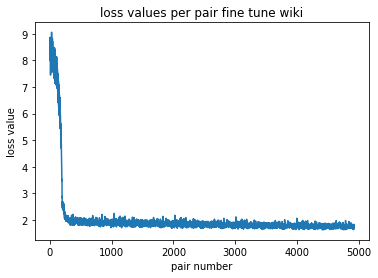

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)),losses)
plt.title('loss values per pair fine tune wiki')
plt.xlabel('pair number')
plt.ylabel('loss value')
plt.show()

#Train advance to intermediate

In [ ]:
dataset_1 = load_dataset('csv', data_files={'train': '/content/ADV_INT_train_one_stop_english.csv',
                                              'test': '/content/ADV_INT_train_one_stop_english.csv'})

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-fc8166b206728a61/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length= 128)

tokenized_datasets = dataset_1.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

from torch.utils.data import DataLoader

full_train_dataset = tokenized_datasets["train"]
train_dataloader = DataLoader(full_train_dataset, shuffle=False, batch_size=8)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer, int(num_training_steps*0.1), num_training_steps
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpt.to(device)

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): FrozenBNBEmbedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): FrozenBNBLinear(4096, 4096)
          (v_proj): FrozenBNBLinear(4096, 4096)
          (q_proj): FrozenBNBLinear(4096, 4096)
          (out_proj): FrozenBNBLinear(4096, 4096)
        )
        (mlp): GPTJMLP(
          (fc_in): FrozenBNBLinear(4096, 16384)
          (fc_out): FrozenBNBLinear(16384, 4096)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0

In [ ]:
from tqdm.auto import tqdm

scaler = torch.cuda.amp.GradScaler()
progress_bar = tqdm(range(num_training_steps))
gpt.train()
gpt.gradient_checkpointing_enable()
k = 0
losses1 = []
count = 0 

for epoch in range(num_epochs):
    for batch in train_dataloader:

        k = k + 1
        if k % 500 == 0:
          print(k)
        

        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
          out = gpt.forward(**batch,)

          loss1 = F.cross_entropy(out.logits[:, :-1, :].flatten(0, -2), batch['input_ids'][:, 1:].flatten(),
                                reduction='mean', label_smoothing=0.1)
          
        print(loss1)
        losses1.append(loss1.item())
        scaler.scale(loss1).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(gpt.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        lr_scheduler.step()
        progress_bar.update(1)

  0%|          | 0/1285 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.1540, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.2483, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.0431, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.4713, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.2438, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6447, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.8003, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.9516, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.9204, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.9012, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.0493, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.1794, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7249, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.8900, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4873, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6427, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7848, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.8706, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4394, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5870, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7379, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7589, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5185, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4879, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3624, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4336, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3934, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4744, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3172, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4221, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3361, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4557, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5454, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1683, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5484, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2666, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4188, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1377, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3145, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2659, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2190, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4680, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1701, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0436, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4477, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2068, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3547, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2750, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2627, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2931, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2291, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1397, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2782, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2139, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3760, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0894, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1733, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0427, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0293, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1255, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1805, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4766, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1176, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2027, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2102, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2216, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1038, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5531, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1530, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3792, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1046, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3275, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2497, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0926, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5376, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3601, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1084, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0268, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2158, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0180, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1685, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1760, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4310, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2407, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0668, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0364, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2903, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1299, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2743, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4735, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3710, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1042, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4838, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4305, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1802, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0450, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2184, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3020, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2687, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2757, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3257, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1777, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3604, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3136, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2915, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2429, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2094, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1889, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2896, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1666, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1749, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4368, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1359, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1318, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2577, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0843, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2180, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4520, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1996, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1562, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4510, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0937, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1654, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2299, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4706, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0679, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3263, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1987, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2280, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1802, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0289, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0613, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9319, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3746, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1411, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2548, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3834, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1309, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1729, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0694, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0307, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2998, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1533, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2650, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4154, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2514, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1352, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1645, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0749, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2464, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2830, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0916, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4059, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3922, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3037, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1731, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2022, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1816, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1740, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9647, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4306, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3917, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2337, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0616, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1952, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4262, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1022, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9906, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2987, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4607, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2325, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2388, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1980, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1690, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1066, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4453, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3394, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0695, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3769, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2254, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2885, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3460, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9588, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1214, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2247, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0683, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3037, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1140, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3039, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2911, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9808, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3035, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2412, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2477, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5300, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2675, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1933, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3314, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1953, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1602, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3680, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5425, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0724, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3112, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1411, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1137, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1976, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2237, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2527, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0767, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3680, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1114, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2785, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2445, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1105, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2437, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3076, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0602, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1279, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0719, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1962, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5180, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3036, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1667, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1848, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0880, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2589, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2583, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2614, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1727, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1547, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1629, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0900, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2804, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2352, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2053, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2387, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3272, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0894, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1070, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1264, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1164, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3894, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1731, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0795, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3594, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9072, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3633, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2304, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4047, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4981, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3413, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3839, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3033, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5554, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4546, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9592, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0586, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1555, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1668, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2493, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3123, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3346, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1099, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2377, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0265, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1339, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2675, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3560, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0426, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2178, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3469, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3142, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1453, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1665, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0753, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1734, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1477, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1884, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0702, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1312, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1808, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3111, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0057, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3440, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0775, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1861, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0241, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1591, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1150, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1005, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3180, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0622, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9597, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2761, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0959, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2348, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1562, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1470, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1695, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0609, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1737, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1045, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2743, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0138, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0911, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9677, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9244, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0421, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0924, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3414, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0302, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1049, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0975, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1402, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0399, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4328, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0711, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2804, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0188, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2528, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1517, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9838, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4283, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9589, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1271, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9533, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0899, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0677, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3132, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9174, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1176, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9824, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9787, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1789, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1703, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0522, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1513, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3449, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2669, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0429, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3736, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3038, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0890, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9591, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1161, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2109, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1633, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1615, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0766, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2434, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1970, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1874, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1566, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1194, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0858, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1847, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0833, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0797, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3146, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0477, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1539, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9882, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1284, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3286, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1092, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0484, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3024, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0040, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0604, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1309, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3547, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9761, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2243, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1104, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1295, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0565, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9456, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9808, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8606, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2595, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0268, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1620, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2783, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0606, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0838, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9887, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9436, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2009, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0796, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1691, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2668, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1332, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0540, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0749, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9747, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1698, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0108, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3065, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2081, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2802, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1907, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0933, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1120, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0894, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0685, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8755, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3467, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1366, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9903, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0976, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3091, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0198, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8801, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1126, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3148, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1246, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1462, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1215, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0727, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0095, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3404, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2273, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0053, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2636, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1289, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1647, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2041, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8758, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0340, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1064, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0026, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1873, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0324, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1770, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1549, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9156, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2202, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1446, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1507, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4139, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1523, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1010, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2159, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1084, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0736, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2526, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4090, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9826, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2059, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0596, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2409, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0251, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1069, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1344, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1522, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0188, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2629, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0502, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1701, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1274, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0233, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1451, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2065, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9837, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0331, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0086, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1011, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3976, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2064, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0876, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0951, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0046, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1659, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1626, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2459, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1547, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0855, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0705, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0646, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0183, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1889, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1383, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


500
tensor(2.1581, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2013, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0101, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0176, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0674, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0318, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2802, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0824, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0182, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2623, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8726, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2409, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1744, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3009, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3446, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2455, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2714, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2215, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4097, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3535, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8977, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9814, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0893, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0788, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1584, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2098, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2414, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0199, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1499, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9699, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0758, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1948, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2419, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9837, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1424, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2411, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2185, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0620, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0889, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0082, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0931, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0617, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1090, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0059, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1050, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0446, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1002, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2013, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9470, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2377, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0174, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1148, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9612, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0811, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0445, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0263, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2331, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9956, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9003, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1827, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0255, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1522, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0713, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0630, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0940, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0346, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0010, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0937, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0292, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9365, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0147, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9077, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8536, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9804, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0079, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2165, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9583, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0121, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0177, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0637, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9795, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2773, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9970, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1895, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9458, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1635, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0581, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2958, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1619, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9526, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8958, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0480, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8963, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0230, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9734, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2079, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8387, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0233, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9188, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9283, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0771, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0858, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9743, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0591, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2224, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1632, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9897, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2689, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1905, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0016, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9001, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0373, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1115, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0627, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0657, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1250, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9962, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1521, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1088, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1047, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0803, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0433, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9968, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0980, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0122, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9967, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2020, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9803, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9887, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0671, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9113, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0302, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2038, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0304, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9793, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1948, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9450, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9798, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0522, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2543, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9207, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1127, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0396, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0396, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9629, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8745, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9081, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8011, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1291, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9362, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0917, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1881, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9949, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0148, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9167, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8812, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1166, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0061, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0901, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1403, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9768, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9970, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9042, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0456, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0726, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9486, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2095, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1193, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1833, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1045, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0262, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0256, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0109, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9964, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8232, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2320, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1933, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1626, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0472, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9279, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0247, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1786, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9492, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7961, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9811, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2073, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0449, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0696, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0530, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0160, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9379, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2548, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1271, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9418, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1560, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0454, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0694, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1077, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8176, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9507, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0338, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9415, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0944, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9550, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0713, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0573, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8616, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1380, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0664, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0654, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3202, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0695, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0237, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1146, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0323, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9997, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1534, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3121, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9059, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1235, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9862, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1582, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9549, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0385, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0555, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0755, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9687, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1756, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9890, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0946, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0383, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9569, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0641, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1235, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9158, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9601, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9402, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0241, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2921, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1145, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0166, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0131, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9340, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0890, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0960, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1666, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0807, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0181, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9987, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9969, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9667, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0985, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0722, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0514, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0809, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1197, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9422, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9582, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0045, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9574, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1939, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0024, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1713, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8322, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1401, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0924, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2094, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2409, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1496, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1650, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1361, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2923, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2512, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8453, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9102, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0262, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9966, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0784, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1120, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1663, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9539, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0817, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9295, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0134, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1127, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1523, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9307, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0718, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1587, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1463, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9832, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0278, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9513, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0244, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9914, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0395, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9586, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0511, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9728, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0276, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1097, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8939, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1358, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9593, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0460, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9011, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9993, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9835, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9663, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1523, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9303, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8522, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1158, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9619, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0849, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9985, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9948, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9605, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9454, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0813, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8758, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9395, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8447, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8033, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9244, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9315, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1295, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8932, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9394, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9528, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0064, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9178, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1767, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9378, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0968, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8863, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0868, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8524, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2012, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0848, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9013, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8448, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9862, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8493, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9521, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9046, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1240, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7785, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9429, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8607, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8873, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0007, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0035, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9069, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9718, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1325, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0729, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9386, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1916, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1024, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9321, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8443, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9614, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0415, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9966, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9881, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0429, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9187, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0680, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0354, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0348, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0022, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9763, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9318, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0208, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9521, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9307, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1123, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9267, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9198, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9928, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8489, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9534, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1210, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9624, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9176, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1024, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8921, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9131, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9743, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1696, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8580, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0246, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9745, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9662, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8837, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8067, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8394, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7645, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0425, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8557, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0128, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1173, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9293, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9484, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8630, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8491, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0392, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9499, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0203, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0479, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9617, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8983, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9270, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8411, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9678, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9913, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8845, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1208, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0356, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1196, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0382, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9587, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9464, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9418, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9253, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7643, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1903, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1211, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0912, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9705, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8643, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9540, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0855, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8757, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7262, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8940, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1411, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9689, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0005, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9874, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9544, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8613, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1834, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0606, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8840, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0920, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9854, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9941, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0444, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7793, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9000, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9683, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8983, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0326, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8948, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0174, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9834, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8163, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0674, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0090, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0026, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2648, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0124, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9603, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9714, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9326, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0837, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2605, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8531, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0590, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0807, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9002, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9836, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9876, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0234, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9066, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1050, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9392, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0310, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9732, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9038, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0140, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8608, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8986, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8824, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9597, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2156, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0367, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


1000
tensor(1.9664, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9561, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8787, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0233, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0362, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0939, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0169, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9536, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9440, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9374, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9159, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0263, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0210, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9836, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0113, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0664, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8910, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9000, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9512, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9147, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1199, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9350, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8936, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1145, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7984, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0774, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0367, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1450, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1371, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0945, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0922, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0732, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2222, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1751, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8009, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8583, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9741, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9399, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0104, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0490, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1054, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8903, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0224, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8941, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9677, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0512, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0878, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8814, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0127, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1056, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0868, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9216, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9792, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9041, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9609, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9352, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9791, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9037, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9949, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9101, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9776, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0546, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8518, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0751, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9145, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9929, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8545, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9365, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9249, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9148, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0855, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8870, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8143, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0668, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9119, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0269, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9459, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9474, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9595, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9169, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8922, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9805, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9158, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0205, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8277, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8862, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7956, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7669, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8741, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8756, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0591, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8425, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8852, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9023, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9542, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8723, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1185, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8887, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0384, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8425, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0593, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9204, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8167, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1388, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0273, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8558, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8035, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9342, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8988, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8602, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0639, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7395, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8887, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8191, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8411, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9374, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9554, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8559, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9225, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0697, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0206, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8908, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1299, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0378, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8788, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7948, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9218, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9885, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9433, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9454, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9842, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8734, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0132, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9919, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9853, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9455, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9345, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8867, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9601, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9053, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8872, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0795, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8792, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8752, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9423, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8260, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9152, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0676, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9272, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8831, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0441, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8471, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8699, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9262, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8058, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9793, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9356, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9215, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8444, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7726, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7914, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7271, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9945, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8096, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9610, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0633, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8856, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9071, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8177, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8107, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9921, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9051, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9728, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9971, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9230, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8668, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8904, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8030, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9269, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9533, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8431, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0738, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0063, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0808, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9949, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9222, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9007, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8955, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8701, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7340, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1501, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0678, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0441, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9205, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8242, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9156, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0351, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8286, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6809, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8334, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0904, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9264, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9576, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9455, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9051, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8135, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0215, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8437, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0464, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9425, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9528, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0011, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7447, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8517, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9260, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8558, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9901, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8618, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9653, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9457, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7787, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0185, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9650, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9568, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2425, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9716, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9350, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0327, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9398, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8939, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0481, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2152, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8164, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0347, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8779, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0538, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8654, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9521, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9618, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9925, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8760, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0649, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9028, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9838, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9408, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8830, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9820, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0196, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8275, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8613, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8492, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9212, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1800, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9886, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9345, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9269, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8489, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9906, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0010, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0547, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9843, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9185, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9069, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8996, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8851, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0012, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9896, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9445, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9761, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0318, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8622, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8717, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9157, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8864, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0884, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9091, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8588, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0886, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7818, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0428, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0015, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1302, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1162, device='cuda:0', grad_fn=<AddBackward0>)


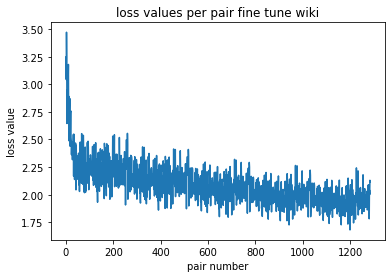

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses1)),losses1)
plt.title('loss values per pair fine tune wiki')
plt.xlabel('pair number')
plt.ylabel('loss value')
plt.show()

#Train intermediate to elemntre

In [ ]:
dataset_2 = load_dataset('csv', data_files={'train': '/content/INT_ELE_train_one_stop_english.csv',
                                              'test': '/content/INT_ELE_train_one_stop_english.csv'})

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c73f046065fbfc24/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length= 128)

tokenized_datasets = dataset_2.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

from torch.utils.data import DataLoader

full_train_dataset = tokenized_datasets["train"]
train_dataloader = DataLoader(full_train_dataset, shuffle=False, batch_size=8)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer, int(num_training_steps*0.1), num_training_steps
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpt.to(device)

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): FrozenBNBEmbedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): FrozenBNBLinear(4096, 4096)
          (v_proj): FrozenBNBLinear(4096, 4096)
          (q_proj): FrozenBNBLinear(4096, 4096)
          (out_proj): FrozenBNBLinear(4096, 4096)
        )
        (mlp): GPTJMLP(
          (fc_in): FrozenBNBLinear(4096, 16384)
          (fc_out): FrozenBNBLinear(16384, 4096)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0

In [ ]:
from tqdm.auto import tqdm

scaler = torch.cuda.amp.GradScaler()
progress_bar = tqdm(range(num_training_steps))
gpt.train()
gpt.gradient_checkpointing_enable()
k = 0
losses2 = []
count = 0 

for epoch in range(num_epochs):
    for batch in train_dataloader:

        k = k + 1
        if k % 500 == 0:
          print(k)
        

        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
          out = gpt.forward(**batch,)

          loss2 = F.cross_entropy(out.logits[:, :-1, :].flatten(0, -2), batch['input_ids'][:, 1:].flatten(),
                                reduction='mean', label_smoothing=0.1)
          
        print(loss2)
        losses2.append(loss2.item())
        scaler.scale(loss2).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(gpt.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        lr_scheduler.step()
        progress_bar.update(1)

  0%|          | 0/985 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4759, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1746, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5170, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4682, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1403, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1510, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1933, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0697, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2355, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1535, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2277, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1977, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1265, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2082, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2069, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0907, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0478, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0653, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0893, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0071, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9551, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0903, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8760, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2541, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3628, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2459, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9315, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0207, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9650, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0049, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2436, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1612, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0596, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9383, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9506, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0918, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9377, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9475, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0907, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0574, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8653, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1544, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0432, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1455, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2069, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9663, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9920, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0469, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1129, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9280, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9966, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9476, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0918, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2921, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9731, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0666, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1087, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2551, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8626, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0043, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1207, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0512, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7795, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0065, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9597, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0785, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1536, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9938, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1701, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0032, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9208, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0822, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2724, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0156, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0517, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0605, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1952, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9429, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1598, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0816, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0225, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0346, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0094, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0090, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0208, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0838, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0732, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0301, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0392, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0102, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0216, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0524, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1384, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1308, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1662, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0738, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0566, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1295, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0259, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9725, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0848, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9548, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8131, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9800, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1028, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9679, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0498, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0927, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0276, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0914, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1863, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0590, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2889, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0225, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0930, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9286, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9801, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1563, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9994, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0665, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1039, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0971, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0268, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0441, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8639, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0131, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1795, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8931, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0940, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0169, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1481, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8046, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8457, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2139, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1541, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0512, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9854, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9336, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9815, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9460, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9897, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1101, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0178, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0573, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9650, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9331, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9568, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1734, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0713, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1312, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1880, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9747, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2186, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0803, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2639, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1388, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0951, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0808, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9609, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0901, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0754, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9247, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0025, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0741, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0648, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0781, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0229, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9780, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1078, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1051, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9645, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0288, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9534, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1577, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9958, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9960, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0105, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9509, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0085, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0059, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1168, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9845, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0261, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0785, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0728, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0403, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1495, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9706, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8584, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9255, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0181, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0022, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9973, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0279, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3281, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0511, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2954, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3059, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9731, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0040, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0392, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9440, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0940, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0508, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0979, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0851, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9974, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1087, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1046, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9644, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9825, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9706, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9724, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9030, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8778, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9658, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8287, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1266, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2468, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1656, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8440, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9543, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8933, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9282, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1910, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1108, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0046, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9168, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9301, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0470, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9155, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9181, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0467, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0172, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8243, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0694, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9907, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0750, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1665, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9307, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9261, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0008, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0428, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8742, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9533, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9003, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0185, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2170, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9088, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9809, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0202, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1859, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8198, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9498, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0405, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9926, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8003, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7354, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9181, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8967, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9956, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0763, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9271, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0631, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9205, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8347, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9934, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1593, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9698, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9640, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0952, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8510, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0466, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9881, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9281, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9403, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9202, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9168, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9243, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9577, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9641, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9289, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9215, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9141, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8848, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9389, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0147, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0450, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9348, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9538, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0169, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9044, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8683, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9715, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8429, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7360, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8644, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9850, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8663, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9514, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9933, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9253, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9741, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0625, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9587, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1495, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9241, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9707, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8402, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8707, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0330, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8945, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9577, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9913, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9793, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9307, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9457, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7942, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9145, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8205, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9807, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9305, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0265, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7186, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7218, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0732, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0613, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9309, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8768, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8344, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8702, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8498, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9056, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0013, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9234, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9611, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8780, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8354, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8638, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0607, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1796, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9839, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0587, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8896, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1174, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9739, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1214, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0361, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9756, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9588, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8781, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9542, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9649, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8480, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8968, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9698, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9574, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9704, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9383, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8883, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0032, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0053, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8561, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9169, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8456, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9036, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0403, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9109, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9049, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9197, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8764, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9184, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9142, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0055, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9015, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9307, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9840, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9660, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9450, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0526, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8767, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8111, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8561, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9210, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9199, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9199, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9110, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1924, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9666, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1979, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1580, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8926, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8984, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9352, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8622, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9791, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9453, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9749, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9832, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8945, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9930, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9771, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8896, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8730, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8757, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8855, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8183, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8014, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8994, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7581, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0273, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1202, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0474, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7949, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8705, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8518, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0730, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0112, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9175, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8365, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8402, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9580, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8173, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8442, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9520, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9497, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7491, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9566, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8963, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9553, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0366, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8520, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8348, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9039, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9542, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8001, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8659, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8113, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9124, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1181, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8114, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8785, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9193, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0609, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7610, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8607, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9357, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9092, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7281, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6834, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8343, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8196, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9066, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9769, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9371, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8260, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7626, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8982, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0553, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8570, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8745, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8659, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0045, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7658, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9643, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9071, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8368, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8600, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8356, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8321, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8247, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8515, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8586, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8494, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8347, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8308, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7893, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8410, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9068, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9525, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9767, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8503, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8509, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9299, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8126, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7821, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8829, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7592, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6735, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7721, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


500
tensor(1.8910, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7815, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8493, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9017, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8293, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9114, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9727, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8610, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0444, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8476, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8781, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7502, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7911, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9500, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8112, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8722, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8898, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8960, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8475, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8489, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7242, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8403, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9447, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7433, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8813, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8447, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9391, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6568, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6374, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9717, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9688, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8391, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7766, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7621, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7802, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7789, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9116, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8430, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8682, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8022, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7492, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7942, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9657, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0743, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8950, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9312, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9568, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8155, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0334, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8861, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9833, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8794, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8855, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7985, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8818, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8794, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7773, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8312, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8724, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8665, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8913, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8526, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8017, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9216, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9259, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7555, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8411, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7702, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8103, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9572, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8371, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8340, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8334, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8080, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8474, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8357, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9153, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8351, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8655, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9004, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8832, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8693, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9639, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8096, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7668, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7966, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8471, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8407, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8530, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8526, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1038, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8901, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1274, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0590, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8148, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8245, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7949, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8866, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8610, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8950, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9060, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8252, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9001, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8734, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8274, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7944, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7951, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8032, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7605, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7402, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8206, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6987, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9289, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0395, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9627, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7417, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8034, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7698, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7960, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0012, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9196, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8414, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7731, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7722, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8797, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7477, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7729, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8716, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8731, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6940, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8792, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8171, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8735, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9437, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7877, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7615, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8102, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8839, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7418, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7930, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7456, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8379, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0210, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7475, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8093, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8437, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9640, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7046, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7888, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8658, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8336, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6766, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6517, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7672, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7475, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8374, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9035, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7661, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8431, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7651, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6923, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8262, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9851, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7918, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8001, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7877, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9255, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6945, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8895, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8349, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7590, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8002, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7832, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7674, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7489, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7801, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7870, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7696, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7551, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7597, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7238, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7710, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8474, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9168, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9258, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7719, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7750, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8756, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7617, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7174, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8160, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7413, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6274, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7078, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8331, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7230, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7812, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8258, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7597, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8480, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8976, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8045, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9649, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7820, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8039, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6998, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7454, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8805, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7495, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8071, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8216, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8303, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7811, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7892, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6696, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7736, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8748, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6894, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8129, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7835, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8738, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6024, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5835, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9008, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9136, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7827, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7067, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7075, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7259, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7169, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7929, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8485, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7923, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8196, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7514, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6853, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7449, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9050, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9927, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8220, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8571, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8965, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7590, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9844, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8371, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9540, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9283, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8307, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8226, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7295, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8248, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8314, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7312, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7902, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8113, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8075, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8267, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7948, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7455, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8653, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8645, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7030, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7782, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7499, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8996, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7675, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7756, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7715, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7489, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7818, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7907, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8544, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7818, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8181, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8401, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8306, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8095, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9048, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7570, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7137, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7364, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7993, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7767, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7946, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7752, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0522, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8319, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0641, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9797, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7565, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7566, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8072, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7542, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8311, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8002, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8371, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8472, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7695, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8373, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8137, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7745, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7508, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7390, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7467, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7166, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6819, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7704, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6564, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8757, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9694, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8975, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6996, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7645, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7272, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7464, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9382, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8564, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8056, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7268, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7268, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8367, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6953, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7262, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8296, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8135, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6564, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8299, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7678, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8101, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8846, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7447, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7107, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7565, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8224, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6981, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7469, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6991, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8046, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9697, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7047, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7601, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7811, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9057, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6580, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7436, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7820, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6476, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6246, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7297, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7055, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7896, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8480, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7282, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7955, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7043, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6539, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7703, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9367, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7481, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7578, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7400, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8833, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6541, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8482, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7803, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7266, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7484, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7384, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7262, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7015, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7476, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7502, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7218, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7260, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7254, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6880, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7287, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8020, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8605, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8599, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7295, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7442, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8303, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7192, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6776, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7745, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6899, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5967, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6795, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7934, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7047, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7393, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7741, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8039, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8471, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7526, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9189, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7268, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7565, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6622, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7025, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8337, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7235, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7706, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7723, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7823, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7397, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7431, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6318, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7359, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8240, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6568, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7714, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7301, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8268, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5735, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.5520, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8616, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8539, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7460, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6750, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6864, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6907, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7677, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8040, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7541, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8040, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7195, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6604, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7017, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8677, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9538, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7734, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8217, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8537, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7349, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9641, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8058, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9308, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8984, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7887, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7894, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7041, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7924, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8019, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7067, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7704, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7701, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7857, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8083, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7545, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7187, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8373, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8532, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6846, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7592, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6936, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7388, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8674, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7432, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7482, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7526, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7252, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7647, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7524, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8388, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7522, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7854, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8086, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7928, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7836, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8758, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7321, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6922, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7111, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7926, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7609, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7716, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7367, device='cuda:0', grad_fn=<AddBackward0>)


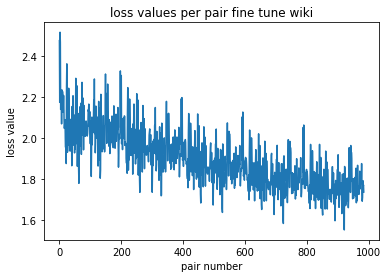

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses2)),losses2)
plt.title('loss values per pair fine tune wiki')
plt.xlabel('pair number')
plt.ylabel('loss value')
plt.show()

In [ ]:
torch.save(gpt.state_dict(), 'gdrive/MyDrive/Final Project Data/model_tensor_all_lora_without_newsela.pt')

#Train on Newsela data

#Train advance to intermediate

In [ ]:
dataset_3 = load_dataset('csv', data_files={'train': '/content/df_newSela_fine_tune_ad_int_train.csv',
                                              'test': '/content/df_newSela_fine_tune_ad_int_train.csv'})

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-46590028e4f42f28/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length= 128)

tokenized_datasets = dataset_3.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

from torch.utils.data import DataLoader

full_train_dataset = tokenized_datasets["train"]
train_dataloader = DataLoader(full_train_dataset, shuffle=False, batch_size=8)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer, int(num_training_steps*0.1), num_training_steps
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpt.to(device)

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): FrozenBNBEmbedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): FrozenBNBLinear(4096, 4096)
          (v_proj): FrozenBNBLinear(4096, 4096)
          (q_proj): FrozenBNBLinear(4096, 4096)
          (out_proj): FrozenBNBLinear(4096, 4096)
        )
        (mlp): GPTJMLP(
          (fc_in): FrozenBNBLinear(4096, 16384)
          (fc_out): FrozenBNBLinear(16384, 4096)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0

In [ ]:
from tqdm.auto import tqdm

scaler = torch.cuda.amp.GradScaler()
progress_bar = tqdm(range(num_training_steps))
gpt.train()
gpt.gradient_checkpointing_enable()
k = 0
losses3 = []
count = 0 

for epoch in range(num_epochs):
    for batch in train_dataloader:

        k = k + 1
        if k % 500 == 0:
          print(k)
        

        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
          out = gpt.forward(**batch,)

          loss3 = F.cross_entropy(out.logits[:, :-1, :].flatten(0, -2), batch['input_ids'][:, 1:].flatten(),
                                reduction='mean', label_smoothing=0.1)
          
        print(loss3)
        losses3.append(loss3.item())
        scaler.scale(loss3).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(gpt.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        lr_scheduler.step()
        progress_bar.update(1)

  0%|          | 0/960 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7654, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.9336, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.0087, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7877, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7046, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.9064, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(3.1128, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6682, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6565, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5824, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7056, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6012, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.7130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6002, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6190, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6245, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6506, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6570, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6449, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5463, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5040, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4463, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6818, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3082, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2093, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2843, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2444, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.6420, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4501, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4560, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.5595, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2871, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3546, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2517, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3512, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2446, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3468, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1462, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1489, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2726, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0629, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1962, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2965, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2108, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1499, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1585, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1703, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0992, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2006, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0580, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1777, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3988, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1855, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1179, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9609, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1823, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2064, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2157, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1830, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1035, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9674, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2190, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2386, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3485, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0114, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1283, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2466, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2585, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1065, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1516, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0610, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1082, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0328, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1078, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2833, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0055, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1278, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9916, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1502, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0931, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1240, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0724, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0723, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0489, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0705, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0452, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0281, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1321, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0800, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2669, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2019, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1010, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1026, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9365, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1278, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2214, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2508, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0966, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1235, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9433, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1173, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0344, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9275, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0877, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1462, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1407, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1806, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9677, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2549, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1989, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0004, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1725, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1337, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1297, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0713, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0390, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0798, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0806, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2132, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1320, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1304, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0595, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1084, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3459, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0706, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9519, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1813, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0986, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1316, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1584, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1766, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2629, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9932, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1247, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0262, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0974, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1229, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2007, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1492, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2672, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0211, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3120, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0489, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0785, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2877, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1679, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1046, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0496, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9913, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0449, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1123, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1073, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9948, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1392, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9560, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0088, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1810, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1815, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1787, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2435, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0679, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2100, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1782, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9489, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1225, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3403, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9726, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0090, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1538, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0882, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0996, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0407, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0832, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0658, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9920, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0221, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0727, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1377, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1232, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1989, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0550, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0084, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9918, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9672, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1149, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9850, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0151, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0497, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9629, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0125, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1535, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2311, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1032, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0199, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1315, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2232, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0278, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0086, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9476, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0667, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0340, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1068, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0043, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0492, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0010, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1504, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1543, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1614, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1261, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0893, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0669, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2087, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9742, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9353, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0078, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9970, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2640, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1807, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1613, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2740, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0634, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1401, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0386, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1740, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0530, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1588, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9898, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0199, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1151, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9462, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0426, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1511, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0593, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0175, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0490, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9776, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0681, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9630, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0590, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2698, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0712, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0121, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8906, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0717, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0854, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0856, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0677, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9960, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8771, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1149, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1199, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2096, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9256, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0242, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1102, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1193, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9950, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0191, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9484, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0080, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9294, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0072, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1474, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9275, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0228, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9029, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0488, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9963, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0157, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9778, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9654, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9789, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9650, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9101, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9383, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9344, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0173, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9654, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1642, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0409, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9971, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9979, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8563, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0091, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0665, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1115, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9753, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0259, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8692, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9937, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9516, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8336, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9955, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0386, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0042, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0555, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8909, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1106, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0437, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9277, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0687, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0349, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9412, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0187, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9658, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9200, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9811, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9962, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0753, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0142, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0437, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9648, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0099, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1909, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9661, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8604, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0525, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9915, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0419, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0606, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0603, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1173, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9199, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0205, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9486, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0101, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0383, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0851, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0545, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1006, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9122, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1653, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9519, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9438, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1561, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0367, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0276, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9463, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9012, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9476, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0124, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0178, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9142, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0352, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8847, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0757, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0835, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0816, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1048, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9736, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0569, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0436, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8622, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0159, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2188, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9097, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9482, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0698, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9959, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0120, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9518, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0149, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9842, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9319, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9406, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9886, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0106, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0232, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0979, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9574, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9241, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9268, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9128, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0022, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8985, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9414, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9697, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9104, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9021, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9807, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0435, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1608, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0308, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9335, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0457, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1099, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9544, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9359, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8633, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9866, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9766, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9443, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9728, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9331, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0479, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0532, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0337, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0344, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0062, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9862, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0917, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8875, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8828, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9110, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9089, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1431, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0639, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0716, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1707, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9739, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0495, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9738, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0870, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9729, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0589, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9167, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9487, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0287, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8795, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9633, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0768, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9425, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9434, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9709, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9126, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9906, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8932, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9783, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1630, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9675, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9525, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8359, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9833, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0059, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9894, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9870, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9116, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8194, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0299, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0179, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0930, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8587, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9415, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0034, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0071, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8924, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9057, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8540, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9188, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8657, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9082, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0417, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8680, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9396, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8272, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9535, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9142, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9195, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9113, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8624, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9143, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8856, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8050, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8747, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8658, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9430, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8989, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0587, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9137, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9149, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7811, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9254, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9443, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0135, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8813, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9342, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8004, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9120, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8777, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7684, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9359, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8767, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9498, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8283, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9928, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9354, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8735, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9880, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9675, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8306, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


500
tensor(1.8981, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8777, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8723, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9078, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9169, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9589, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9025, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9748, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8844, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9255, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0391, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8818, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7936, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9470, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9176, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9630, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9753, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9545, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0015, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8588, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9437, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8772, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9344, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9616, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9832, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9760, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9836, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8348, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0212, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8642, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8591, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0436, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9356, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9524, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8597, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8352, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8734, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9403, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9445, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8381, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9502, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8197, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8203, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9854, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9922, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0076, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0010, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8901, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9196, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9354, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8032, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9295, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1210, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8585, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9034, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9772, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9179, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9192, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8828, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9437, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9066, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8743, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8691, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9164, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9070, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9368, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0145, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8803, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8541, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8621, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8618, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9004, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8364, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8721, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8978, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8632, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8130, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9058, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9409, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0540, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9583, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8561, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9684, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0252, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8809, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8801, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7904, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9095, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9199, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9557, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8776, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9097, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8678, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9664, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9700, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9532, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9577, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9364, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8888, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9994, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8114, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8210, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8269, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8291, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0076, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9740, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9950, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0728, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8898, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9714, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8986, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9878, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9108, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9787, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8505, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8795, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9462, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8184, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8868, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9906, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8875, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8705, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8652, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9005, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8533, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9207, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8393, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9047, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0492, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8744, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9021, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7794, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9184, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9316, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9028, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9081, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8264, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7604, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9470, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9195, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0039, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8040, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8830, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9125, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9121, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8210, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8459, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7930, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8310, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8103, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8269, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9502, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8162, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8685, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7690, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8800, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8324, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8363, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8349, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7951, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8574, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8151, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7418, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8053, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8003, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8674, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8244, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9748, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8315, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8384, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8538, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7381, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8632, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8546, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9300, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8119, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8532, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7517, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8429, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8192, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7150, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8329, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8674, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7834, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8692, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7758, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8997, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8483, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8142, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9162, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8975, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7575, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8244, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8015, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7984, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8522, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8412, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8848, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8306, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9148, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8201, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8640, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9441, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8137, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7378, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8748, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8405, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8945, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9135, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8663, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9100, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7948, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8777, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8225, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8680, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8903, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8984, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8885, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9091, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7744, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9417, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7900, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7846, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9593, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8601, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8785, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7992, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7871, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8111, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8728, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8877, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7915, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8863, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7752, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7478, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9103, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9223, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9387, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9259, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8232, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8279, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8635, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7588, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8611, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0454, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8089, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8459, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9125, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8608, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8602, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8217, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8710, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8529, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8171, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8208, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8578, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8319, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8646, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9498, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8179, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7843, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8214, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8084, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8224, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7922, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8137, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8339, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8171, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7403, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8504, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8692, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9865, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8991, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8054, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9026, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9839, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8191, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8317, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7293, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8487, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8648, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8884, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8228, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8516, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8051, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9048, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8991, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8782, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9007, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8759, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8133, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9438, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7684, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7807, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7761, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7751, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9286, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9019, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9381, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0236, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8316, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9101, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8423, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9420, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8534, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9238, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8067, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8192, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8900, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7660, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8311, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9325, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8421, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8244, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8086, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8375, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8243, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8642, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7793, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8436, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9816, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8093, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8658, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7431, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8581, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8826, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8372, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8471, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7708, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7197, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8807, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8652, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9454, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7552, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8302, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8506, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8626, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7714, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8023, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7336, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7709, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7691, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7734, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9039, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7778, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8164, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7286, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8280, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7854, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7989, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7798, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7429, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8081, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7753, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6943, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7537, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7540, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8247, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7747, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9231, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7691, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7915, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8052, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6936, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8116, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7985, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8850, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7557, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8012, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7007, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7923, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7786, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6793, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7846, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8168, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7254, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8125, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7324, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8425, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7918, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7770, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8655, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8555, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7167, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7665, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7477, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7579, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8015, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7996, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8343, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7647, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8749, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7812, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8263, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8881, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7743, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7009, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8270, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7908, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8615, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8649, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8169, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8640, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7497, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8432, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7940, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8280, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8559, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8563, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8456, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8470, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7289, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8908, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7575, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7442, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9087, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8162, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8427, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7577, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7375, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7657, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8302, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8524, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7668, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8488, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7338, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7224, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8722, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8785, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9073, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8857, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8033, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7878, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8256, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7375, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8253, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0000, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7866, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8227, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8766, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8257, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8224, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8025, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8284, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8120, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7888, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7914, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8227, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8007, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8304, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9140, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7839, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7540, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7853, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7873, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7789, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7664, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7811, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8103, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7770, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7085, device='cuda:0', grad_fn=<AddBackward0>)


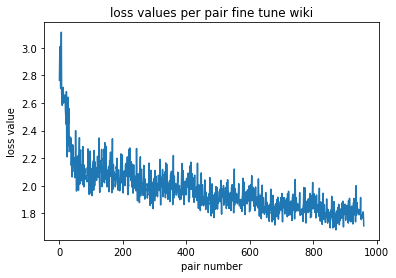

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses3)),losses3)
plt.title('loss values per pair fine tune wiki')
plt.xlabel('pair number')
plt.ylabel('loss value')
plt.show()

# Train intermediate to elementary

In [ ]:
dataset_4 = load_dataset('csv', data_files={'train': '/content/df_newSela_fine_tune_int_el_train.csv',
                                              'test': '/content/df_newSela_fine_tune_int_el_train.csv'})

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-02fbab1e517bbbb4/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length= 128)

tokenized_datasets = dataset_4.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

from torch.utils.data import DataLoader

full_train_dataset = tokenized_datasets["train"]
train_dataloader = DataLoader(full_train_dataset, shuffle=False, batch_size=8)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer, int(num_training_steps*0.1), num_training_steps
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpt.to(device)

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): FrozenBNBEmbedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): FrozenBNBLinear(4096, 4096)
          (v_proj): FrozenBNBLinear(4096, 4096)
          (q_proj): FrozenBNBLinear(4096, 4096)
          (out_proj): FrozenBNBLinear(4096, 4096)
        )
        (mlp): GPTJMLP(
          (fc_in): FrozenBNBLinear(4096, 16384)
          (fc_out): FrozenBNBLinear(16384, 4096)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0

In [ ]:
from tqdm.auto import tqdm

scaler = torch.cuda.amp.GradScaler()
progress_bar = tqdm(range(num_training_steps))
gpt.train()
gpt.gradient_checkpointing_enable()
k = 0
losses4 = []
count = 0 

for epoch in range(num_epochs):
    for batch in train_dataloader:

        k = k + 1
        if k % 500 == 0:
          print(k)
        

        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
          out = gpt.forward(**batch,)

          loss4 = F.cross_entropy(out.logits[:, :-1, :].flatten(0, -2), batch['input_ids'][:, 1:].flatten(),
                                reduction='mean', label_smoothing=0.1)
          
        print(loss4)
        losses4.append(loss4.item())
        scaler.scale(loss4).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(gpt.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        lr_scheduler.step()
        progress_bar.update(1)

  0%|          | 0/70 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0892, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0329, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0835, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0721, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.2294, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0839, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1285, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1274, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9787, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.3486, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1207, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0792, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1404, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.4367, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9745, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9027, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9255, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9351, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0560, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9359, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9619, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0134, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8656, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1359, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9564, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9375, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.0037, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(2.1486, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8636, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7957, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8156, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8087, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9276, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8065, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8481, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8996, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7655, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9882, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8270, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8344, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8892, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.9720, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7488, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7012, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7294, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7209, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8321, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7245, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7545, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8106, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7025, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8958, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7495, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7589, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8041, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7713, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6847, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6523, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6740, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6653, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7891, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6711, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7116, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7536, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6614, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.8299, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7040, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7181, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.7753, device='cuda:0', grad_fn=<AddBackward0>)


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


tensor(1.6860, device='cuda:0', grad_fn=<AddBackward0>)


#saving the wights 

In [ ]:
torch.save(gpt.state_dict(), 'gdrive/MyDrive/Final Project Data/model_tensor_all_lora_with_newsela_new.pt')

In [ ]:
# torch.save(gpt.state_dict(), 'gdrive/MyDrive/IDC_Final/all_togther.pt')

Text generation example


In [ ]:
gpt.eval()
with torch.no_grad():
  prompt = tokenizer("Quote:", truncation=True, padding=True, max_length=128, return_tensors='pt')
  prompt = {key: value.to(device) for key, value in prompt.items()}
  out = gpt.generate(**prompt, max_length=128, top_k=50, top_p=0.9, temperature=1.0, do_sample=True, repetition_penalty = 1.2, num_beams=1)
  print(tokenizer.decode(out[0]))

In [ ]:
gpt.eval()
with torch.no_grad():
  prompt = tokenizer("""simplify the text to elementary: 
 text: The Seattle-based company has applied for its brand to be a top-level domain name (currently .com), but the South American governments argue this would prevent the use of this internet address for environmental protection, the promotion of indigenous rights and other public interest uses.
 
 to::""", truncation=True, padding=True, max_length=128, return_tensors='pt')
  prompt = {key: value.to(device) for key, value in prompt.items()}
  out = gpt.generate(**prompt, max_length=128, top_k=50, top_p=0.9, temperature=1.0, do_sample=True, repetition_penalty = 1.2, num_beams=1)
  print(tokenizer.decode(out[0]))

In [ ]:
gpt.eval()
with torch.no_grad():
  prompt = tokenizer("""my name is yonatan""", truncation=True, padding=True, max_length=128, return_tensors='pt')
  prompt = {key: value.to (device) for key, value in prompt.items()}
  out = gpt.generate(**prompt, max_length=128, top_k=50, top_p=0.9, temperature=1.0, do_sample=True, repetition_penalty = 1.2, num_beams=1)
  print(tokenizer.decode(out[0]))